### Import required Python libraries and set plotting parameters 


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import time
import os
import os.path
import zipfile
import pandas as pd
from scipy.optimize import curve_fit, least_squares, brute, brent
import gmsh
import math
import pyvista as pv
import re
import pickle

from matplotlib.colors import ListedColormap
pv.set_plot_theme("document")

plt.rcParams['figure.figsize'] = [12, 9]
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.family'] = "DejaVu Serif"
plt.rcParams['font.size'] = 20

from pyvirtualdisplay import Display
display = Display(backend="xvfb", visible=False, size=(800, 600))
display.start()
    
user_name=!whoami # get user name
user_name=user_name[0]
um_view = "/mofem_install/jupyter/%s/um_view" % user_name

### Define utility functions including black-box launch of MoFEM


In [3]:
class AttrDict(dict):
    def __getattr__(self, attr):
        if attr in self:
            return self[attr]
        raise AttributeError(f"'AttrDict' object has no attribute '{attr}'")
    def __setattr__(self, key, value):
        self[key] = value

def replace_template_sdf(params):
    regex = r"\{(.*?)\}"
    with open(params.template_sdf_file) as infile, open(params.sdf_file, 'w') as outfile:
        for line in infile:
            matches = re.finditer(regex, line, re.DOTALL)
            for match in matches:
                for name in match.groups():
                    src = "{" + name + "}"
                    target = str(params[name])
                    line = line.replace(src, target)
            outfile.write(line)

def get_young_modulus(K, G):
    E = 9. * K * G /(3. * K + G)
    return E

def get_poisson_ratio(K, G):
    nu = (3. * K - 2. * G) / 2. / (3. * K + G)
    return nu

def get_bulk_modulus(E, nu):
    K = E / 3. / (1. - 2. * nu)
    return K

def get_shear_modulus(E, nu):
    G = E / 2. / (1. + nu)
    return G

def parse_log_file(params):
    time, indent, force = [], [], []
    with open(params.log_file, "r") as log_file:
        for line in log_file:
            line = line.strip()
            if "Contact force" in line:
                line = line.split()
                time.append(float(line[6]))
                force.append(float(line[8]))
            if "Uy" in line:
                line = line.split()
                indent.append(abs(float(line[7])))
    return np.array(time), np.array(indent), np.array(force)

def get_indentation_data(params):
    with open(params.data_file, 'rb') as f:
        dataframes = pickle.load(f)

    max_steps = 0
    max_indent = 0
    for struct_id, df in dataframes.items():
        min_indentation = df['Time'].min()
        df['Time'] = df['Time'] - min_indentation
        df['Indentation'] *= 1e6
        df['Force'] *= 1e9
        
        df = df[df['Indentation'] <= params.cutoff_indent]
        
        dataframes[struct_id] = df
        
        max_steps = max(max_steps, len(df))
        max_indent = max(max_indent, df['Indentation'].max())

    num_curves = len(dataframes)
    print(f"Number of curves in the final set: {num_curves}")

    df = dataframes[params.curve_id]
    df.to_csv(params.curve_file, index=False)

    params.time_exp = np.asarray(df['Time'])
    params.indent_exp = np.asarray(df['Indentation'])
    params.force_exp = np.asarray(df['Force'])

    # Get the length of the DataFrame
    params.load_step_num = int(len(df) / params.sample_step) 
    print(f"Length of DataFrame: {params.load_step_num}")

    # Get the maximum value of the 'Time' column
    params.final_time = df['Time'].max()
    print(f"Maximum Time: {params.final_time}")

    # Get the maximum value of the 'Indentation' column
    params.max_indentation = df['Indentation'].max()
    print(f"Maximum Indentation: {params.max_indentation}")
    
    common_indent_steps = np.linspace(0, max_indent, num=max_steps)  # Use max_points for resolution

    interpolated_forces = []
    for struct_id, df in dataframes.items():
        interpolated_force = np.interp(common_indent_steps, df['Indentation'], df['Force'])
        interpolated_forces.append(interpolated_force)

    # Convert the list of interpolated forces to a DataFrame
    interpolated_forces_df = pd.DataFrame(interpolated_forces, columns=common_indent_steps)

    # Calculate the mean Force at each common time step
    mean_forces = interpolated_forces_df.mean(axis=0)

    # Calculate the 25th and 75th percentiles (IQR)
    percentile_25 = interpolated_forces_df.quantile(0.25, axis=0)
    percentile_75 = interpolated_forces_df.quantile(0.75, axis=0)

    # Create a DataFrame to hold the common time steps, mean forces, and IQR
    mean_force_df = pd.DataFrame({
        'Indentation': common_indent_steps,
        'Mean_Force': mean_forces,
        'IQR_25': percentile_25,
        'IQR_75': percentile_75
    })
    
    params.mean_force_df = mean_force_df
    return params

def mofem_compute_force_indent(params):    
    !rm -rf out*
    
    mi_param_2 = 0
    mi_param_3 = 0
    mi_param_4 = 0
    
    if params.material_model == "LinearElasticity":
        mi_block = "LinearElasticity"
        mi_param_0 = params.young_modulus
        mi_param_1 = params.poisson_ratio
    elif params.material_model == "SaintVenantKirchhoffElasticity":
        mi_block = "SaintVenantKirchhoffElasticity"
        mi_param_0 = params.young_modulus
        mi_param_1 = params.poisson_ratio
    elif params.material_model == "NeoHookeanHyperElasticity":
        mi_block = "SignoriniHyperElasticity"
        mi_param_0 = get_bulk_modulus(params.young_modulus, params.poisson_ratio)
        mi_param_1 = 0.5 * get_shear_modulus(params.young_modulus, params.poisson_ratio)
    elif params.material_model == "StandardLinearSolid":
        mi_block = "StandardLinearSolid"
        mi_param_0 = get_bulk_modulus(params.young_modulus_0, params.poisson_ratio_0)
        mi_param_1 = get_shear_modulus(params.young_modulus_0, params.poisson_ratio_0)
        mi_param_2 = get_bulk_modulus(params.young_modulus_1, params.poisson_ratio_1)
        mi_param_3 = get_shear_modulus(params.young_modulus_1, params.poisson_ratio_1)
        mi_param_4 = params.relax_time_1
    else:
        print("Unknown material model: " + params.material_model)
        return
    
    params.time_step = params.final_time / params.load_step_num 
        
    !export OMPI_MCA_btl_vader_single_copy_mechanism=none && \
    nice -n 10 mpirun --oversubscribe --allow-run-as-root \
    -np {params.nproc} {um_view}/tutorials/adv-1/contact_2d \
    -file_name {params.part_file} \
    -sdf_file {params.sdf_file} \
    -order {params.order} \
    -ts_dt {params.time_step} \
    -ts_max_time {params.final_time} \
    -mi_lib_path_{params.mfront_block_id} {um_view}/mfront_interface/libBehaviour.so \
    -mi_block_{params.mfront_block_id} {mi_block} \
    -mi_param_{params.mfront_block_id}_0 {mi_param_0} \
    -mi_param_{params.mfront_block_id}_1 {mi_param_1} \
    -mi_param_{params.mfront_block_id}_2 {mi_param_2} \
    -mi_param_{params.mfront_block_id}_3 {mi_param_3} \
    -mi_param_{params.mfront_block_id}_4 {mi_param_4} \
    -mi_save_volume {int(params.save_volume)} \
    -mi_save_gauss 0 \
    2>&1 | tee {params.log_file}

    time, indent, force = parse_log_file(params)
    
    if params.save_volume:
        !convert.py -np {params.nproc} out*
    
    return time, indent, force

def show_results(params):
    out_to_vtk = !ls -c1 out_*h5m
    last_file=out_to_vtk[0]
    print(last_file)
    !mbconvert {last_file} {last_file[:-3]}vtk
    
    import pyvista as pv
    import matplotlib.pyplot as plt
    from matplotlib.colors import ListedColormap
    import matplotlib.image as mpimg
    import re, os

    mesh = pv.read(last_file[:-3] + "vtk")

    mesh=mesh.warp_by_vector('DISPLACEMENT', factor=1)
    if params.show_edges:
        mesh=mesh.shrink(0.95)
    
    if params.show_field == "DISPLACEMENT" or params.show_field == "displacement":
        field = "DISPLACEMENT"
        if params.show_component == "X" or params.show_component == 'x':
            comp = 0
        elif params.show_component == "Y" or params.show_component == 'y':
            comp = 1
        else:
            print("Wrong component {0} of the field {1}".format(params.show_component, params.show_field))
            return
        
    if params.show_field == "STRESS" or params.show_field == "stress":
        field = "STRESS"
        if params.show_component == "X" or params.show_component == "x":
            comp = 0
        elif params.show_component == "Y" or params.show_component == "y":
            comp = 4
        elif params.show_component == "XY" or params.show_component == "xy":
            comp = 1
        else:
            print("Wrong component {0} of the field {1}".format(params.show_component, params.show_field))
            return

    p = pv.Plotter(notebook=True)
    p.add_mesh(mesh, scalars=field, component=comp, show_edges=True, smooth_shading=False, cmap="turbo")
    
    circle = pv.Circle(radius=params.indenter_radius, resolution=1000)
    circle = circle.translate((0, params.indenter_radius - params.max_indentation, 0), inplace=False)
    p.add_mesh(circle, color="grey")
    
    p.camera_position = "xy"
    p.show(jupyter_backend='ipygany')


def generate_config(params):
    with open(params.config_file, 'w') as f:
        data = [f"[block_2]", f"id={params.mfront_block_id}", "add=BLOCKSET", f"name=MFRONT_MAT_{params.mfront_block_id}"]
        for line in data:
            f.write(line + '\n')
        for axis in ['X', 'Y']:
            data = [f"[SET_ATTR_FIX_{axis}]", "number_of_attributes=1", "user1=0"]
            for line in data:
                f.write(line + '\n')
    return
            
def generate_mesh(params):
    gmsh.initialize()
    gmsh.model.add("Nanoindentation")
    
    a = params.refine_radius    
    H = params.mesh_height 
    L = params.mesh_length
    
    # Creating points
    tol = 1e-3
    point1 = gmsh.model.geo.addPoint(0, 0, 0, tol)
    point2 = gmsh.model.geo.addPoint(0, -a, 0, tol)
    point3 = gmsh.model.geo.addPoint(a, 0, 0, tol)
    point4 = gmsh.model.geo.addPoint(0, -H, 0, tol)
    point5 = gmsh.model.geo.addPoint(L, -H, 0, tol)
    point6 = gmsh.model.geo.addPoint(L, 0, 0, tol)

    # Creating connection lines
    arc1 = gmsh.model.geo.addCircleArc(point3, point1, point2)
    line1 = gmsh.model.geo.addLine(point1, point2)
    line2 = gmsh.model.geo.addLine(point2, point4)
    line3 = gmsh.model.geo.addLine(point4, point5)
    line4 = gmsh.model.geo.addLine(point5, point6)
    line5 = gmsh.model.geo.addLine(point6, point3)
    line6 = gmsh.model.geo.addLine(point3, point1)
    
    loop1 = gmsh.model.geo.addCurveLoop([line1, -arc1, line6])
    surface1 = gmsh.model.geo.addPlaneSurface([loop1])
    
    loop2 = gmsh.model.geo.addCurveLoop([arc1, line2, line3, line4, line5])
    surface2 = gmsh.model.geo.addPlaneSurface([loop2])

    # This command is mandatory and synchronize CAD with GMSH Model. The less you launch it, the better it is for performance purpose
    gmsh.model.geo.synchronize()
    
    domain = gmsh.model.addPhysicalGroup(2, [surface1, surface2])
    gmsh.model.setPhysicalName(2, domain, '!_DOMAIN')
    contact = gmsh.model.addPhysicalGroup(1, [line5, line6])
    gmsh.model.setPhysicalName(1, contact, 'CONTACT')
    fix_x = gmsh.model.addPhysicalGroup(1, [line1, line2])
    gmsh.model.setPhysicalName(1, fix_x, 'FIX_X')
    fix_y = gmsh.model.addPhysicalGroup(1, [line3])
    gmsh.model.setPhysicalName(1, fix_y, 'FIX_Y')

    gmsh.model.mesh.setSize(gmsh.model.getEntitiesInBoundingBox(0, -H, 0, L, 0, 0), params.far_field_size)
    gmsh.model.mesh.setSize(gmsh.model.getEntitiesInBoundingBox(0, -a, 0, a, 0, 0), params.near_field_size)
    gmsh.model.mesh.generate(2)    

    # Save mesh
    gmsh.write(params.med_file)

    # Finalize GMSH = END OF CODE=
    gmsh.finalize()
    
    generate_config(params)
    
    !read_med -med_file {params.med_file} -output_file {params.mesh_file} -meshsets_config {params.config_file} -log_sl inform
    
    #partition the mesh into nproc parts
    !{um_view}/bin/mofem_part \
    -my_file {params.mesh_file} \
    -my_nparts {params.nproc} \
    -output_file {params.part_file} \
    -dim 2 -adj_dim 1
    
    if params.show_mesh:
        !mbconvert {params.mesh_file} {params.vtk_file}

        mesh = pv.read(params.vtk_file )
        mesh = mesh.shrink(0.95)

        p = pv.Plotter(notebook=True)
        p.add_mesh(mesh, smooth_shading=False)

        circle = pv.Circle(radius=params.indenter_radius, resolution=1000)
        circle = circle.translate((0, params.indenter_radius, 0), inplace=False)

        p.add_mesh(circle, color="grey")
        p.camera_position = "xy"
        p.show(jupyter_backend='ipygany')
    
    return

def residual_mofem_indent(var, params):     
    params.young_modulus_0 = var[0]
    params.young_modulus_1 = var[1]
    params.relax_time_1 = var[2]
    
    time_mofem, indent_mofem, force_mofem = mofem_compute_force_indent(params)
    force_mofem = force_mofem[1:]
    indent_mofem = indent_mofem[1:]

    force_exp = np.interp(indent_mofem, params.indent_exp, params.force_exp)
    res_mofem = (force_mofem - force_exp) 
        
    ls = 0.5 * np.linalg.norm(res_mofem) ** 2
    
    with open(params.opt_file, 'a') as file:
         file.write(f'{params.young_modulus_0} {params.young_modulus_1} {params.relax_time_1} {ls}\n')
        
    return res_mofem

def residual_mofem_time(var, params):     
    params.young_modulus_0 = var[0]
    params.young_modulus_1 = var[1]
    params.relax_time_1 = var[2]
    
    time_mofem, indent_mofem, force_mofem = mofem_compute_force_indent(params)
    force_mofem = force_mofem[1:]
    time_mofem = time_mofem - time_mofem[1]
    time_mofem = time_mofem[1:]

    force_exp = np.interp(time_mofem, params.time_exp, params.force_exp)
    res_mofem = force_mofem - force_exp

    ls = 0.5 * np.linalg.norm(res_mofem) ** 2
    
    with open(params.opt_file, 'a') as file:
         file.write(f'{params.young_modulus_0} {params.young_modulus_1} {params.relax_time_1} {ls}\n')
        
    return res_mofem

def hertz_fit(indent, E):  
    Es = E / (1. - params.poisson_ratio**2)
    return 4./3. * Es * np.sqrt(params.indenter_radius) * pow(np.abs(indent), 3./2.)

def residual_hertz(var, params):
    E, nu = var
    Es = E / (1 - nu**2)
    
    
    force_hertz = 4./3. * Es * np.sqrt(params.indenter_radius) * pow(params.indent_exp, 3./2.)
    
    res = (np.asarray(force_hertz) - np.asarray(params.force_exp)) / np.asarray(params.error_exp)
    
    ls = 0.5 * np.linalg.norm(res) ** 2
    print(E, nu, ls)
    
    with open(params.opt_file, 'a') as file:
        file.write(f'{E} {nu} {ls}\n')
        
    return ls

def hertz_area(indent, params):   
    return np.pi * indent * params.indenter_radius

def hertz_sls(t, E0, E1, tau1): 
    nu = 0.47
    E = E0 + E1 * np.exp(-t / tau1)
    
    Es = E / (1 - nu**2)
    indent_exp = np.interp(t, params.time_exp, params.indent_exp)
    return 4./3. * Es * np.sqrt(params.indenter_radius) * pow(indent_exp, 3./2.)

def mean(values):
    if not values:
        return 0  # Return 0 if the list is empty to avoid division by zero
    return sum(values) / len(values)

### Sketch of the problem setup

<!-- 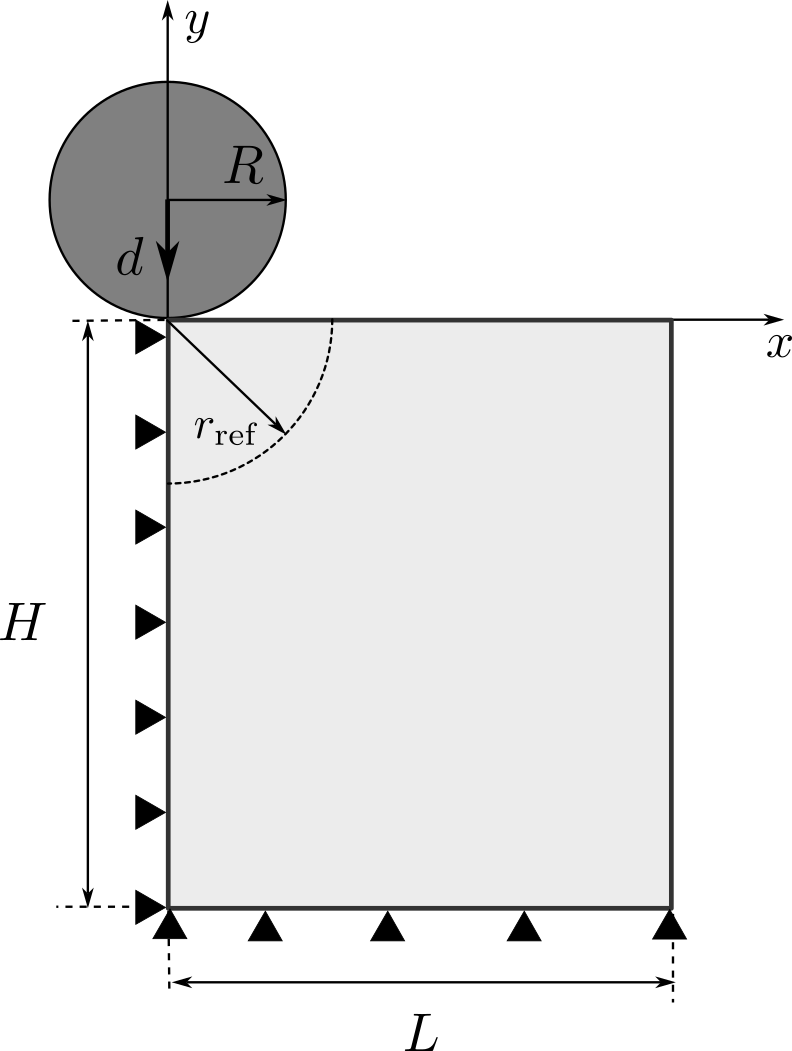 -->
<div>
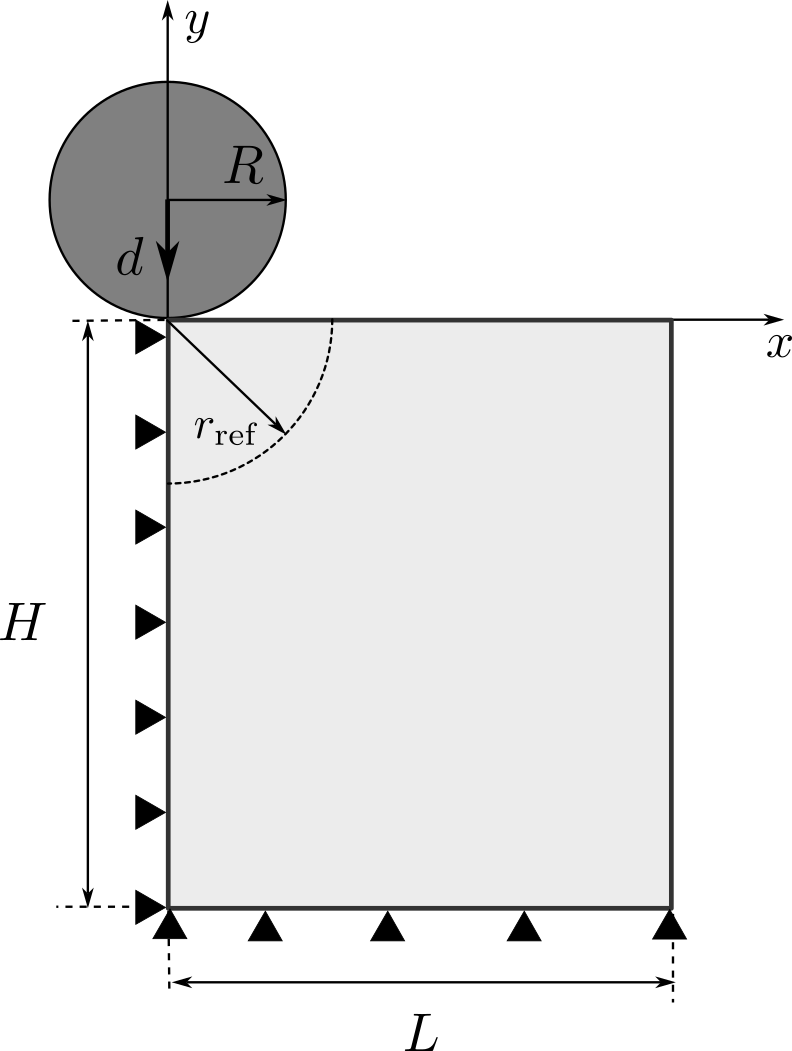
</div>

### Set simulation parameters

In [4]:
params = AttrDict()

params.curve_file = "curve.csv"
params.data_file = "data/gel3_viscoelastic_indent.pkl"
params.curve_id = "curve3" 

params.sample_step = 1
params.indenter_radius = 27.5 # um
params.cutoff_indent = params.indenter_radius
get_indentation_data(params)

params.med_file = "mesh_2d.med"
params.mesh_file = "mesh_2d.h5m"
params.vtk_file = "mesh_2d.vtk"

params.load_hist = "load.txt"
params.log_file = "log_indent"
params.opt_file = "log_indent_opt"

params.sdf_file = "sdf_indent.py"

params.config_file = "bc.cfg"
params.mfront_block_id = 10

params.nproc = 6 # number of processors/cores used
params.order = 2 #order of approximation functions

params.part_file = os.path.splitext(params.mesh_file)[0] + "_" + str(params.nproc) + "p.h5m"

params.refine_radius = np.sqrt(params.indenter_radius * params.max_indentation) * 1.1 # a_hertz = sqrt(R * d)

params.mesh_length = params.refine_radius * 50 # L
params.mesh_height = params.mesh_length * 2    # H

params.near_field_size = params.refine_radius / 10
params.far_field_size = params.mesh_height / 10

params.save_volume = False # save results for post-processing

generate_config(params)

Number of curves in the final set: 69
Length of DataFrame: 166
Maximum Time: 0.16500000000000004
Maximum Indentation: 2.9187298805384603


### Visualise experimental data

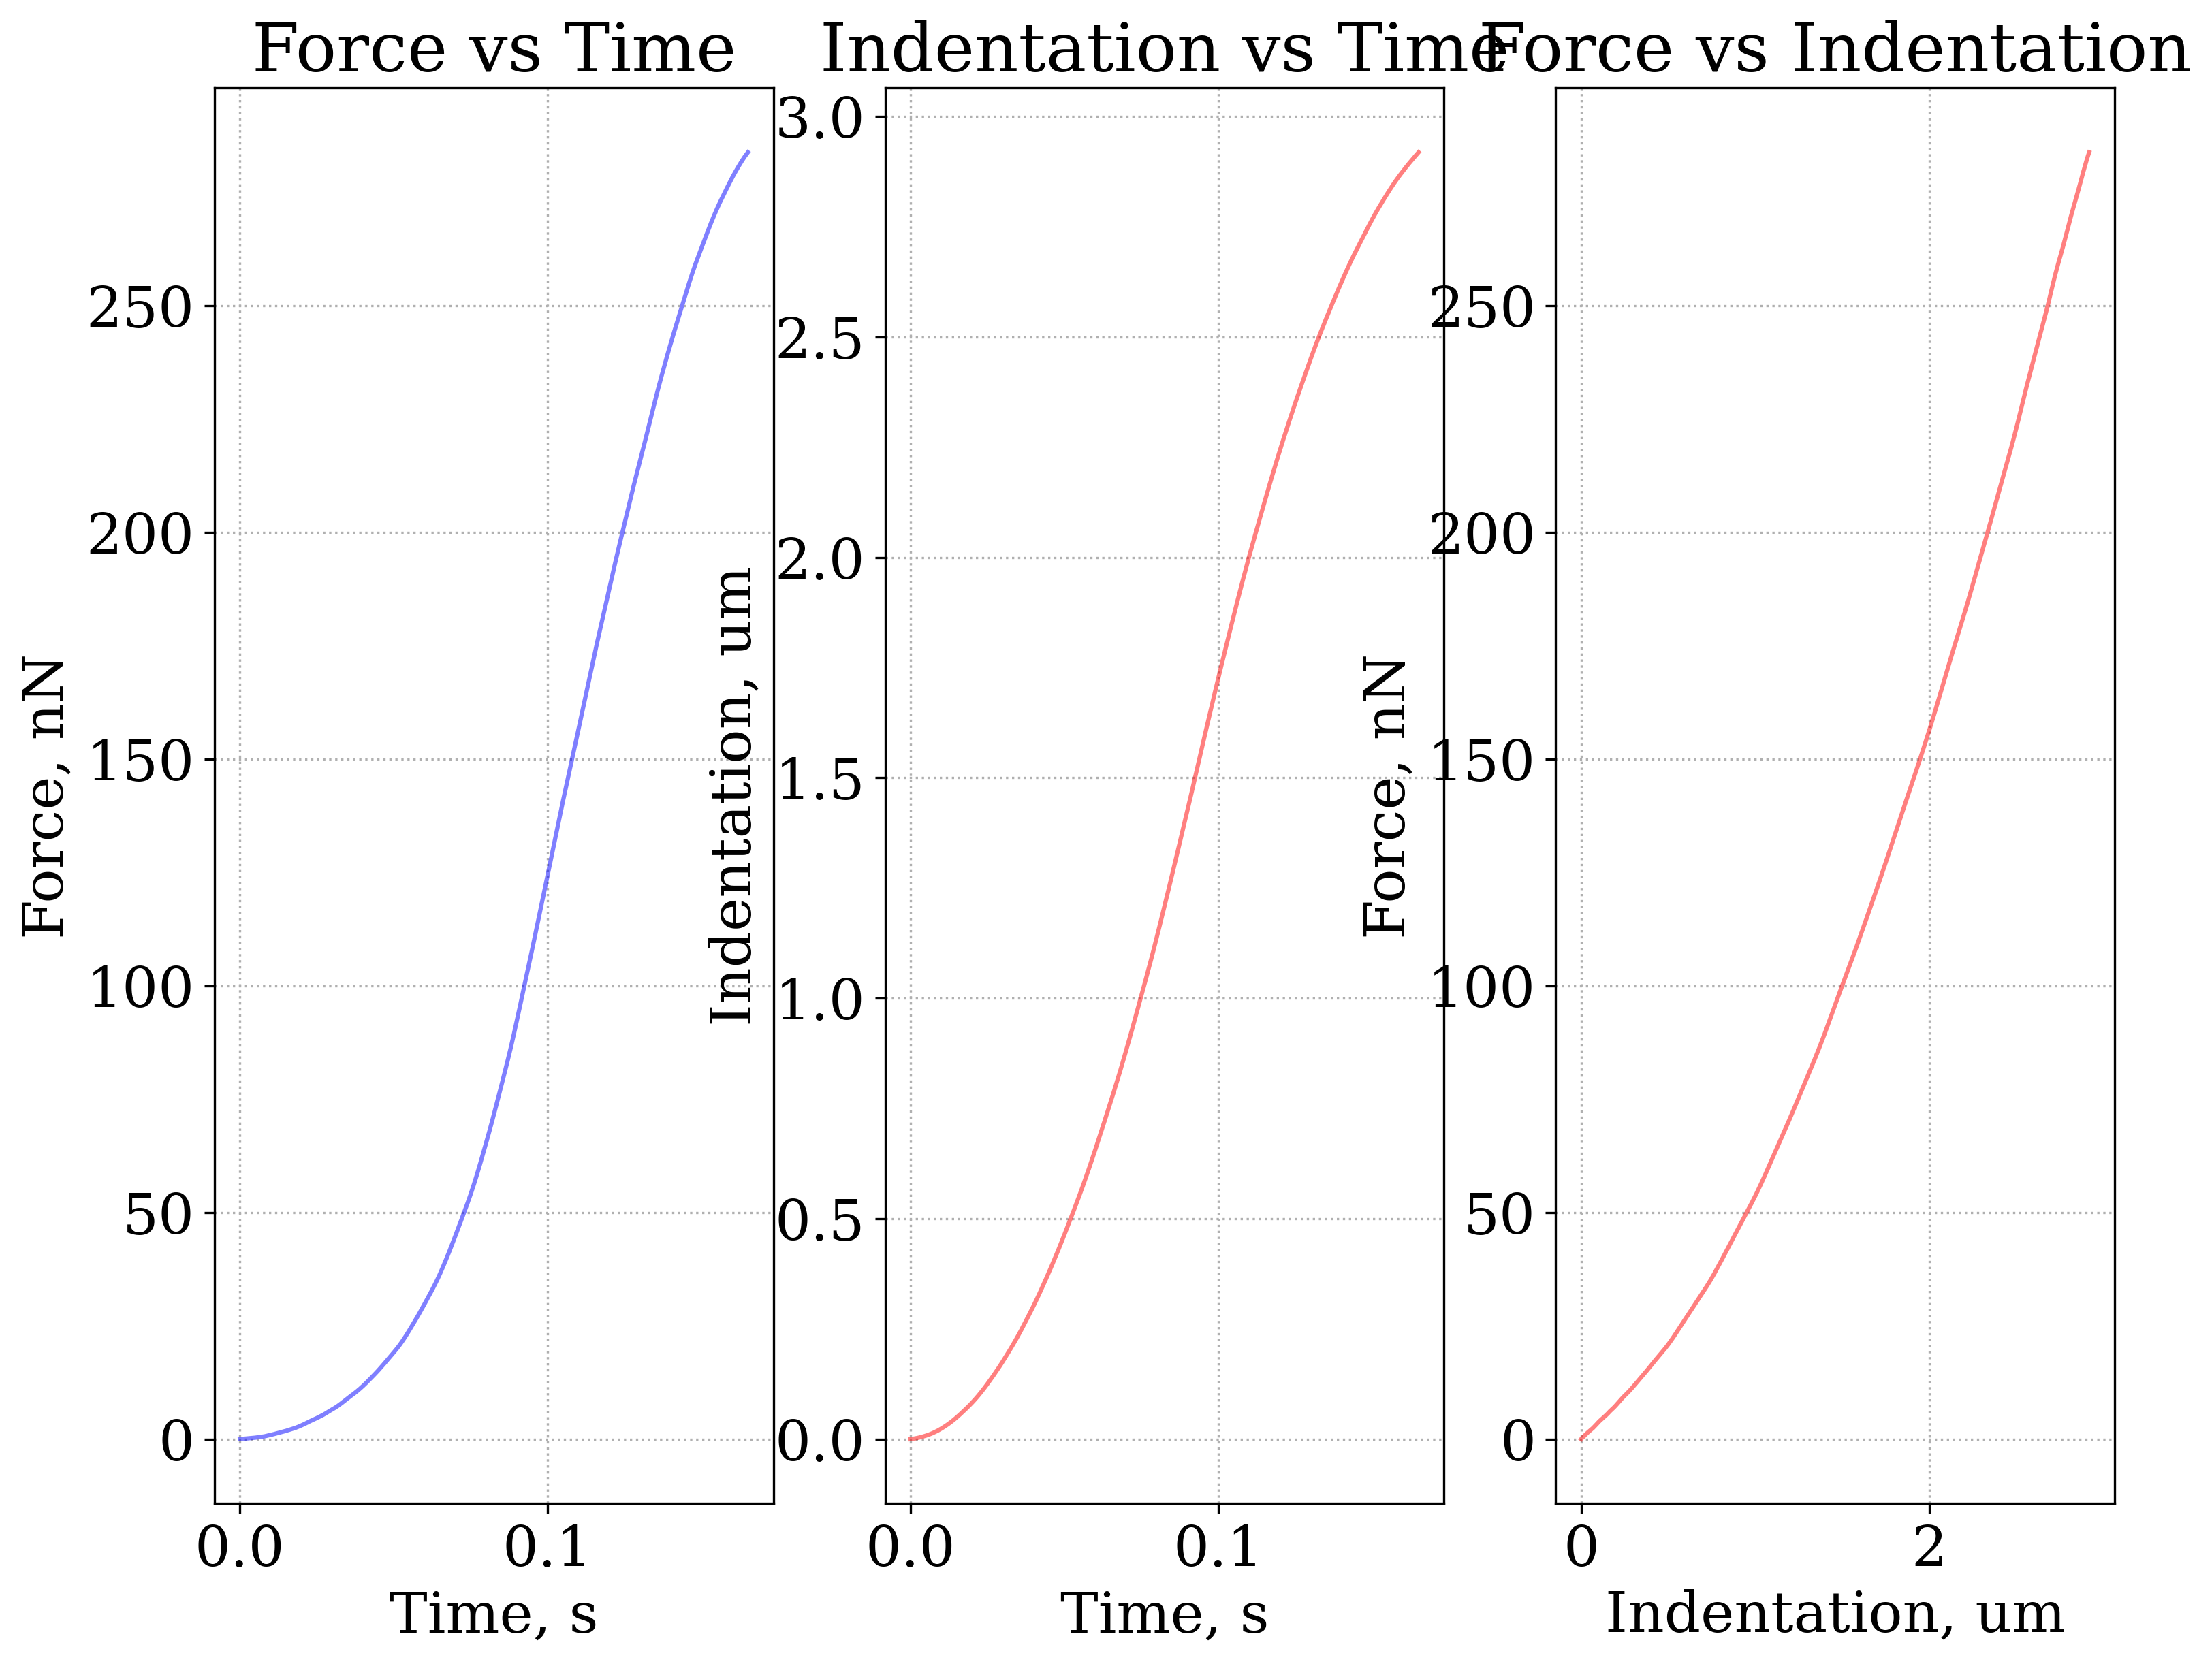

In [5]:
fig, axs = plt.subplots(1, 3)

# Plot Force vs Time
axs[0].plot(params.time_exp, params.force_exp, label='Force vs Time', color='b', alpha=0.5)
axs[0].set_xlabel('Time, s')
axs[0].set_ylabel('Force, nN')
axs[0].set_title('Force vs Time')
axs[0].grid(ls=':')
# axs[0].legend()

# Plot Force vs Indentation
axs[1].plot(params.time_exp, params.indent_exp, label='Indentation vs Time', color='r', alpha=0.5)
axs[1].set_xlabel('Time, s')
axs[1].set_ylabel('Indentation, um')
axs[1].set_title('Indentation vs Time')
axs[1].grid(ls=':')

# Plot Force vs Indentation
axs[2].plot(params.indent_exp, params.force_exp, label='Force vs Indentation', color='r', alpha=0.5)
axs[2].set_xlabel('Indentation, um')
axs[2].set_ylabel('Force, nN')
axs[2].set_title('Force vs Indentation')
axs[2].grid(ls=':')

### Generate mesh

In [6]:
params.show_mesh = True
generate_mesh(params)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Circle)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 30%] Meshing curve 3 (Line)
Info    : [ 50%] Meshing curve 4 (Line)
Info    : [ 60%] Meshing curve 5 (Line)
Info    : [ 80%] Meshing curve 6 (Line)
Info    : [ 90%] Meshing curve 7 (Line)
Info    : Done meshing 1D (Wall 0.00794102s, CPU 0.00829s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 50%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0148255s, CPU 0.011254s)
Info    : 574 nodes 1168 elements
Info    : Writing 'mesh_2d.med'...
Info    : Done writing 'mesh_2d.med'
[0] <inform> MoFEM version 0.14.0 (MOAB 5.5.0 Petsc Release Version 3.16.6, Mar 30, 2022 )
[0] <inform> git commit id 36417344c7fc1dc382b2327a0c42d6329ac1d3bd
[0] <inform> Local time: 2024-7-2 17:18:30
[0] <inform> UTC time: 2024-7-2 17:18:30
[0] <inform> [MED] Reading MED file V4.1.0 using MED library V4.1.0
[0] <inform> 

Scene(background_color='#ffffff', camera={'position': [232.07656860351562, -465.249267578125, 1123.20070571834…

### Run material identification

In [7]:
cids = np.arange(0, 1)

E0_list = []
E1_list = []
tau1_list = []
cost_list = []

for cid in cids:
    params.curve_id = "curve" + str(cid)
    with open("indent_progress", 'a') as file:
         file.write(params.curve_id + '\n')
            
    params.sample_step = 1
    params.cutoff_indent = 0.05 * params.indenter_radius
    get_indentation_data(params)

    with open(params.opt_file, 'w'):
        pass  

    params.material_model = "StandardLinearSolid" 
    params.poisson_ratio_0 = 0.47
    params.poisson_ratio_1 = 0.47
    
    x_0 = [2, 3, 0.8]
    bounds = ([2, 2.5, 0.5], [3, 4, 1])

    opt = optimize.least_squares(residual_mofem_indent, x0=x_0, args=(params,), method='dogbox', jac='2-point', bounds=bounds, 
                                     diff_step=1e-3, xtol=1e-2, ftol=1e-1, loss='soft_l1', tr_solver='exact')
    E0_list.append(opt.x[0])
    E1_list.append(opt.x[1])
    tau1_list.append(opt.x[2])
    cost_list.append(opt.cost)

Number of curves in the final set: 69
Length of DataFrame: 89
Maximum Time: 0.08800000000000008
Maximum Indentation: 1.369944042307693
[0] <inform> MoFEM version 0.14.0 (MOAB 5.5.0 Petsc Release Version 3.16.6, Mar 30, 2022 )
[0] <inform> git commit id 955b9b2bbf6bc63bb1bea19f87c00effec6ed860
[0] <inform> Local time: 2024-7-2 17:18:37
[0] <inform> UTC time: 2024-7-2 17:18:37
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316738 type BLOCKSET UNKNOWNNAME msId 1 name Nanoindentation
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316739 type BLOCKSET UNKNOWNNAME msId 2 name !_DOMAIN
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316740 type BLOCKSET UNKNOWNNAME msId 3 name CONTACT
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316741 type BLOCKSET UNKNOWNNAME msId 4 name FIX_X
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316748 type BLOCKSET UNKNOWNNAME msId 5 name FIX_Y
[0] <inform>

[0] <inform> [petsc]     1 SNES Function norm 7.694888472625e-14 [  1.013886808228e-16  ,   7.694881793081e-14  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step   0 accepted t=0          + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 1 TS dt 0.000988764 time 0.000988764
[0] <inform> [Indent] Write file at time 0.000988764 write step 1
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.8932e-04 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.2497e-03
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 1.1802e-03 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3

[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.0940e-02 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -7.1958e-02
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 6.8060e-02 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.2299e+01
[0] <inform> [Essential] Total force: 1.0940e-02 6.8060e-02 0.0000e+00
[0] <inform> [Essential] Total moment: 0.0000e+00 0.0000e+00 -2.2371e+01
[0] <inform> [Indent] Ux time 6.9213e-03 min -1.4535e-04 max 1.1119e-03
[0] <inform> [Indent] Uy time 6.9213e-03 min -6.8587e-03 max 1.9959e-03
[0] <inform> [Indent] Contact force time 6.9213e-03 -1.0195632550700428e-03 6.8110310485468034e-02 0.0000000000000000e+00
[0] <inform> [

[0] <inform> [petsc]     0 SNES Function norm 1.446152242653e-03 [  3.053354053019e-05  ,   1.445829869602e-03  ]
[0] <inform> [petsc]     1 SNES Function norm 1.453861253822e-10 [  2.925110316904e-14  ,   1.453861224396e-10  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  12 accepted t=0.0118652  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 13 TS dt 0.000988764 time 0.0128539
[0] <inform> [Indent] Write file at time 0.0128539 write step 13
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 5.3132e-02 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3.4858e-01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <infor

[0] <inform> [petsc]     1 SNES Function norm 1.587085770198e-08 [  1.269197318652e-12  ,   1.587085765123e-08  ]
[0] <inform> [petsc]     2 SNES Function norm 3.473882569844e-14 [  3.369747415402e-14  ,   8.441933815500e-15  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  18 accepted t=0.0177978  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 19 TS dt 0.000988764 time 0.0187865
[0] <inform> [Indent] Write file at time 0.0187865 write step 19
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.0708e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -8.9409e-01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <infor

[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.1774e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.6691e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 1.7500e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -5.7337e+02
[0] <inform> [Essential] Total force: 1.1774e-01 1.7500e+00 0.0000e+00
[0] <inform> [Essential] Total moment: 0.0000e+00 0.0000e+00 -5.7504e+02
[0] <inform> [Indent] Ux time 2.3730e-02 min -1.7371e-03 max 1.3127e-02
[0] <inform> [Indent] Uy time 2.3730e-02 min -1.1712e-01 max 1.1727e-02
[0] <inform> [Indent] Contact force time 2.3730e-02 -6.7111390399964360e-02 1.7512769962138501e+00 0.0000000000000000e+00
[0] <inform> [

[0] <inform> [petsc]     1 SNES Function norm 5.273197116804e-09 [  3.587375911467e-12  ,   5.273195896551e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  30 accepted t=0.0296629  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 31 TS dt 0.000988764 time 0.0306517
[0] <inform> [Indent] Write file at time 0.0306517 write step 31
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.0499e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3.2101e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 3.5194e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.1

[0] <inform> [petsc]     1 SNES Function norm 3.228455554284e-09 [  2.258760172701e-12  ,   3.228454764123e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  36 accepted t=0.0355955  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 37 TS dt 0.000988764 time 0.0365843
[0] <inform> [Indent] Write file at time 0.0365843 write step 37
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.0511e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -5.1996e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 5.8219e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.9

[0] <inform> [petsc]     1 SNES Function norm 1.975896870539e-09 [  2.210856718033e-12  ,   1.975895633661e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  42 accepted t=0.0415281  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 43 TS dt 0.000988764 time 0.0425169
[0] <inform> [Indent] Write file at time 0.0425169 write step 43
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.1548e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -7.8549e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 8.9062e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.9

[0] <inform> [petsc]     1 SNES Function norm 2.127482911994e-08 [  8.589314858237e-12  ,   2.127482738605e-08  ]
[0] <inform> [petsc]     2 SNES Function norm 4.758705630637e-13 [  4.745569731291e-13  ,   3.533372390594e-14  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  48 accepted t=0.0474607  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 49 TS dt 0.000988764 time 0.0484494
[0] <inform> [Indent] Write file at time 0.0484494 write step 49
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.2879e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.1206e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <infor

[0] <inform> [petsc]     1 SNES Function norm 7.954583386160e-09 [  7.276043305868e-12  ,   7.954580058468e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  54 accepted t=0.0533933  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 55 TS dt 0.000988764 time 0.054382
[0] <inform> [Indent] Write file at time 0.054382 write step 55
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.4594e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.5549e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 1.7883e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -5.859

[0] <inform> [petsc]     1 SNES Function norm 1.446340189290e-08 [  1.403374651814e-11  ,   1.446339508447e-08  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  60 accepted t=0.0593258  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 61 TS dt 0.000988764 time 0.0603146
[0] <inform> [Indent] Write file at time 0.0603146 write step 61
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.6608e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.0590e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 2.3779e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00

[0] <inform> [petsc]     1 SNES Function norm 2.322549883246e-08 [  9.572245251003e-12  ,   2.322549685989e-08  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  66 accepted t=0.0652584  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 67 TS dt 0.000988764 time 0.0662472
[0] <inform> [Indent] Write file at time 0.0662472 write step 67
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.9311e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.6895e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 3.1182e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00

[0] <inform> [petsc]     1 SNES Function norm 2.079562779237e-08 [  1.858922606277e-11  ,   2.079561948391e-08  ]
[0] <inform> [petsc]     2 SNES Function norm 1.381326431196e-12 [  1.380256787515e-12  ,   5.434988535725e-14  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  72 accepted t=0.071191   + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 73 TS dt 0.000988764 time 0.0721798
[0] <inform> [Indent] Write file at time 0.0721798 write step 73
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 2.2560e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3.4236e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <infor

[0] <inform> [petsc]     1 SNES Function norm 2.893950024925e-08 [  2.278750841163e-11  ,   2.893949127759e-08  ]
[0] <inform> [petsc]     2 SNES Function norm 1.724976958450e-12 [  1.724179101006e-12  ,   5.245888714100e-14  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  78 accepted t=0.0771236  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 79 TS dt 0.000988764 time 0.0781124
[0] <inform> [Indent] Write file at time 0.0781124 write step 79
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 2.6307e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -4.2671e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <infor

[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 2.9976e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -5.0897e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 5.9502e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.9496e+04
[0] <inform> [Essential] Total force: 2.9976e-01 5.9502e+01 0.0000e+00
[0] <inform> [Essential] Total moment: 0.0000e+00 0.0000e+00 -1.9547e+04
[0] <inform> [Indent] Ux time 8.3056e-02 min -8.8500e-03 max 1.4071e-01
[0] <inform> [Indent] Uy time 8.3056e-02 min -1.2255e+00 max 3.4916e-02
[0] <inform> [Indent] Contact force time 8.3056e-02 -7.5191281336436653e+00 5.9545346598552634e+01 0.0000000000000000e+00
[0] <inform> [

[0] <inform> MoFEM version 0.14.0 (MOAB 5.5.0 Petsc Release Version 3.16.6, Mar 30, 2022 )
[0] <inform> git commit id 955b9b2bbf6bc63bb1bea19f87c00effec6ed860
[0] <inform> Local time: 2024-7-2 17:18:43
[0] <inform> UTC time: 2024-7-2 17:18:43
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316738 type BLOCKSET UNKNOWNNAME msId 1 name Nanoindentation
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316739 type BLOCKSET UNKNOWNNAME msId 2 name !_DOMAIN
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316740 type BLOCKSET UNKNOWNNAME msId 3 name CONTACT
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316741 type BLOCKSET UNKNOWNNAME msId 4 name FIX_X
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316748 type BLOCKSET UNKNOWNNAME msId 5 name FIX_Y
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316742 type BLOCKSET UNKNOWNNAME msId 10 name MFRONT_MAT_10
[0] <inform> [Inden

[0] <inform> [petsc]     0 SNES Function norm 1.353976750815e-04 [  0.000000000000e+00  ,   1.353976750815e-04  ]
[0] <inform> [petsc]     1 SNES Function norm 7.688340878429e-14 [  1.053514879053e-16  ,   7.688333660395e-14  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step   0 accepted t=0          + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 1 TS dt 0.000988764 time 0.000988764
[0] <inform> [Indent] Write file at time 0.000988764 write step 1
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.8933e-04 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.2498e-03
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inf

[0] <inform> [petsc]     1 SNES Function norm 1.375274354405e-11 [  2.365179592560e-15  ,   1.375274334067e-11  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step   6 accepted t=0.00593258 + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 7 TS dt 0.000988764 time 0.00692135
[0] <inform> [Indent] Write file at time 0.00692135 write step 7
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.0943e-02 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -7.1980e-02
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 6.8080e-02 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.2

[0] <inform> [petsc]     1 SNES Function norm 1.453465882376e-10 [  2.847178444893e-14  ,   1.453465854489e-10  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  12 accepted t=0.0118652  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 13 TS dt 0.000988764 time 0.0128539
[0] <inform> [Indent] Write file at time 0.0128539 write step 13
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 5.3153e-02 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3.4872e-01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 3.3019e-01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.0

[0] <inform> [petsc]     1 SNES Function norm 1.587926578005e-08 [  1.269415326868e-12  ,   1.587926572931e-08  ]
[0] <inform> [petsc]     2 SNES Function norm 3.362594892152e-14 [  3.354341414769e-14  ,   2.354529292412e-15  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  18 accepted t=0.0177978  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 19 TS dt 0.000988764 time 0.0187865
[0] <inform> [Indent] Write file at time 0.0187865 write step 19
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.0712e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -8.9444e-01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <infor

[0] <inform> [petsc]     0 SNES Function norm 3.416981888748e-03 [  1.148255405370e-04  ,   3.415052023509e-03  ]
[0] <inform> [petsc]     1 SNES Function norm 1.636736416497e-09 [  8.871013804881e-13  ,   1.636736176095e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  24 accepted t=0.0237303  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 25 TS dt 0.000988764 time 0.0247191
[0] <inform> [Indent] Write file at time 0.0247191 write step 25
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.1596e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.8679e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <infor

[0] <inform> [petsc]     1 SNES Function norm 5.269369530445e-09 [  3.592923937565e-12  ,   5.269368305526e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  30 accepted t=0.0296629  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 31 TS dt 0.000988764 time 0.0306517
[0] <inform> [Indent] Write file at time 0.0306517 write step 31
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.0503e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3.2114e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 3.5209e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.1

[0] <inform> [petsc]     1 SNES Function norm 3.228179953369e-09 [  2.251263351113e-12  ,   3.228179168378e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  36 accepted t=0.0355955  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 37 TS dt 0.000988764 time 0.0365843
[0] <inform> [Indent] Write file at time 0.0365843 write step 37
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.0515e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -5.2017e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 5.8242e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.9

[0] <inform> [petsc]     1 SNES Function norm 1.975747332652e-09 [  2.224660990983e-12  ,   1.975746080185e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  42 accepted t=0.0415281  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 43 TS dt 0.000988764 time 0.0425169
[0] <inform> [Indent] Write file at time 0.0425169 write step 43
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.1553e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -7.8580e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 8.9097e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.9

[0] <inform> [Indent] Write file at time 0.0474607 write step 48
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.2622e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.0547e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 1.2040e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3.9448e+03
[0] <inform> [Essential] Total force: 1.2622e-01 1.2040e+01 0.0000e+00
[0] <inform> [Essential] Total moment: 0.0000e+00 0.0000e+00 -3.9553e+03
[0] <inform> [Indent] Ux time 4.7461e-02 min -6.4620e-03 max 4.8369e-02
[0] <inform> [Indent] Uy time 4.7461e-02 min -4.2066e-01 max 3.5385e-02
[0] <inform> [Indent] Contact force time 4.7461e-02 -8.7388495255347831

[0] <inform> [petsc]     1 SNES Function norm 7.954128302765e-09 [  7.263468982654e-12  ,   7.954124986375e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  54 accepted t=0.0533933  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 55 TS dt 0.000988764 time 0.054382
[0] <inform> [Indent] Write file at time 0.054382 write step 55
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.4600e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.5556e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 1.7890e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -5.861

[0] <inform> [petsc]     0 SNES Function norm 9.901302540914e-03 [  4.238443982880e-04  ,   9.892226641800e-03  ]
[0] <inform> [petsc]     1 SNES Function norm 8.188726441913e-09 [  7.757461591937e-12  ,   8.188722767458e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  61 accepted t=0.0603146  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 62 TS dt 0.000988764 time 0.0613034
[0] <inform> [Indent] Write file at time 0.0613034 write step 62
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.6995e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.1524e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <infor

[0] <inform> [petsc]     1 SNES Function norm 4.336658495698e-08 [  9.019925965289e-12  ,   4.336658401894e-08  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  67 accepted t=0.0662472  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 68 TS dt 0.000988764 time 0.067236
[0] <inform> [Indent] Write file at time 0.067236 write step 68
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.9845e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.8096e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 3.2595e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -

[0] <inform> [Indent] Write file at time 0.0731685 write step 74
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 2.3135e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3.5528e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 4.1338e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.3544e+04
[0] <inform> [Essential] Total force: 2.3135e-01 4.1338e+01 0.0000e+00
[0] <inform> [Essential] Total moment: 0.0000e+00 0.0000e+00 -1.3580e+04
[0] <inform> [Indent] Ux time 7.3169e-02 min -7.8448e-03 max 1.1151e-01
[0] <inform> [Indent] Uy time 7.3169e-02 min -9.6027e-01 max 4.8370e-02
[0] <inform> [Indent] Contact force time 7.3169e-02 -4.5946622095936691

[0] <inform> [petsc]     1 SNES Function norm 3.593281650680e-08 [  2.857411377218e-11  ,   3.593280514559e-08  ]
[0] <inform> [petsc]     2 SNES Function norm 1.858642335875e-12 [  1.857523621706e-12  ,   6.447734104739e-14  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  79 accepted t=0.0781124  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 80 TS dt 0.000988764 time 0.0791011
[0] <inform> [Indent] Write file at time 0.0791011 write step 80
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 2.7021e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -4.4267e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <infor

[0] <inform> [petsc]     0 SNES Function norm 1.768765526506e-02 [  7.981936882394e-04  ,   1.766963597847e-02  ]
[0] <inform> [petsc]     1 SNES Function norm 1.955519603563e-08 [  2.468012513157e-11  ,   1.955518046154e-08  ]
[0] <inform> [petsc]     2 SNES Function norm 2.255265346125e-12 [  2.253426390229e-12  ,   9.105649484940e-14  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  85 accepted t=0.0840449  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 86 TS dt 0.000988764 time 0.0850337
[0] <inform> [Indent] Write file at time 0.0850337 write step 86
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 3.1554e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -5.4424e+01
[0] <inform> [Essential] EssentialPreProc<Displaceme

[0] <inform> [petsc]     1 SNES Function norm 7.685596092670e-14 [  1.043338334863e-16  ,   7.685589010881e-14  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step   0 accepted t=0          + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 1 TS dt 0.000988764 time 0.000988764
[0] <inform> [Indent] Write file at time 0.000988764 write step 1
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.8934e-04 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.2498e-03
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 1.1803e-03 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3

[0] <inform> [petsc]     0 SNES Function norm 5.304677962643e-04 [  1.279774106410e-05  ,   5.303133985646e-04  ]
[0] <inform> [petsc]     1 SNES Function norm 1.482494591534e-11 [  3.468177067392e-15  ,   1.482494550967e-11  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step   7 accepted t=0.00692135 + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 8 TS dt 0.000988764 time 0.00791011
[0] <inform> [Indent] Write file at time 0.00791011 write step 8
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.5011e-02 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -9.8724e-02
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <infor

[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 5.3164e-02 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3.4879e-01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 3.3026e-01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.0821e+02
[0] <inform> [Essential] Total force: 5.3164e-02 3.3026e-01 0.0000e+00
[0] <inform> [Essential] Total moment: 0.0000e+00 0.0000e+00 -1.0856e+02
[0] <inform> [Indent] Ux time 1.2854e-02 min -6.9376e-04 max 5.3778e-03
[0] <inform> [Indent] Uy time 1.2854e-02 min -3.3299e-02 max 9.6979e-03
[0] <inform> [Indent] Contact force time 1.2854e-02 -7.5562830815728279e-03 3.3050083757724891e-01 0.0000000000000000e+00
[0] <inform> [

[0] <inform> [petsc]     1 SNES Function norm 1.588344475590e-08 [  1.268325162592e-12  ,   1.588344470526e-08  ]
[0] <inform> [petsc]     2 SNES Function norm 3.212196400193e-14 [  3.083051167530e-14  ,   9.016657982893e-15  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  18 accepted t=0.0177978  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 19 TS dt 0.000988764 time 0.0187865
[0] <inform> [Indent] Write file at time 0.0187865 write step 19
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.0714e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -8.9462e-01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <infor

[0] <inform> [petsc]     1 SNES Function norm 1.636654160157e-09 [  8.849629540963e-13  ,   1.636653920900e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  24 accepted t=0.0237303  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 25 TS dt 0.000988764 time 0.0247191
[0] <inform> [Indent] Write file at time 0.0247191 write step 25
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.1598e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.8683e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 1.9784e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -6.4

[0] <inform> [petsc]     1 SNES Function norm 5.267462170846e-09 [  3.597945613162e-12  ,   5.267460942056e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  30 accepted t=0.0296629  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 31 TS dt 0.000988764 time 0.0306517
[0] <inform> [Indent] Write file at time 0.0306517 write step 31
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.0505e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3.2120e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 3.5215e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.1

[0] <inform> [petsc]     1 SNES Function norm 3.228059983316e-09 [  2.259762933880e-12  ,   3.228059192356e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  36 accepted t=0.0355955  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 37 TS dt 0.000988764 time 0.0365843
[0] <inform> [Indent] Write file at time 0.0365843 write step 37
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.0517e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -5.2027e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 5.8253e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.9

[0] <inform> [petsc]     1 SNES Function norm 1.975689895050e-09 [  2.209196406040e-12  ,   1.975688659899e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  42 accepted t=0.0415281  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 43 TS dt 0.000988764 time 0.0425169
[0] <inform> [Indent] Write file at time 0.0425169 write step 43
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.1555e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -7.8596e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 8.9115e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.9

[0] <inform> [petsc]     1 SNES Function norm 2.123487002275e-08 [  8.575253622350e-12  ,   2.123486829128e-08  ]
[0] <inform> [petsc]     2 SNES Function norm 4.324891685263e-13 [  4.318360598688e-13  ,   2.375917274482e-14  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  48 accepted t=0.0474607  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 49 TS dt 0.000988764 time 0.0484494
[0] <inform> [Indent] Write file at time 0.0484494 write step 49
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.2886e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.1213e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <infor

[0] <inform> [petsc]     1 SNES Function norm 7.953945016857e-09 [  7.279012468635e-12  ,   7.953941686181e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  54 accepted t=0.0533933  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 55 TS dt 0.000988764 time 0.054382
[0] <inform> [Indent] Write file at time 0.054382 write step 55
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.4603e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.5559e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 1.7894e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -5.862

[0] <inform> [petsc]     1 SNES Function norm 1.445496085817e-08 [  1.399464982514e-11  ,   1.445495408367e-08  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  60 accepted t=0.0593258  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 61 TS dt 0.000988764 time 0.0603146
[0] <inform> [Indent] Write file at time 0.0603146 write step 61
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.6618e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.0602e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 2.3793e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00

[0] <inform> [petsc]     1 SNES Function norm 2.327701995827e-08 [  9.561336499183e-12  ,   2.327701799455e-08  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  66 accepted t=0.0652584  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 67 TS dt 0.000988764 time 0.0662472
[0] <inform> [Indent] Write file at time 0.0662472 write step 67
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.9322e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.6911e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 3.1201e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00

[0] <inform> [petsc]     2 SNES Function norm 1.394405161303e-12 [  1.393743422047e-12  ,   4.295378177882e-14  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  72 accepted t=0.071191   + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 73 TS dt 0.000988764 time 0.0721798
[0] <inform> [Indent] Write file at time 0.0721798 write step 73
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 2.2573e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3.4257e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 3.9843e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.3

[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 2.5632e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -4.1146e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 4.7964e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.5715e+04
[0] <inform> [Essential] Total force: 2.5632e-01 4.7964e+01 0.0000e+00
[0] <inform> [Essential] Total moment: 0.0000e+00 0.0000e+00 -1.5757e+04
[0] <inform> [Indent] Ux time 7.7124e-02 min -8.2706e-03 max 1.2284e-01
[0] <inform> [Indent] Uy time 7.7124e-02 min -1.0620e+00 max 4.9475e-02
[0] <inform> [Indent] Contact force time 7.7124e-02 -5.5989538227644076e+00 4.7999327127103484e+01 0.0000000000000000e+00
[0] <inform> [

[0] <inform> [petsc]     1 SNES Function norm 1.670949681140e-08 [  2.226259297030e-11  ,   1.670948198082e-08  ]
[0] <inform> [petsc]     2 SNES Function norm 2.035192185073e-12 [  2.034232355629e-12  ,   6.249762791626e-14  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  83 accepted t=0.0820674  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 84 TS dt 0.000988764 time 0.0830562
[0] <inform> [Indent] Write file at time 0.0830562 write step 84
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 2.9993e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -5.0927e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <infor

[0] <inform> MoFEM version 0.14.0 (MOAB 5.5.0 Petsc Release Version 3.16.6, Mar 30, 2022 )
[0] <inform> git commit id 955b9b2bbf6bc63bb1bea19f87c00effec6ed860
[0] <inform> Local time: 2024-7-2 17:18:55
[0] <inform> UTC time: 2024-7-2 17:18:55
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316738 type BLOCKSET UNKNOWNNAME msId 1 name Nanoindentation
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316739 type BLOCKSET UNKNOWNNAME msId 2 name !_DOMAIN
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316740 type BLOCKSET UNKNOWNNAME msId 3 name CONTACT
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316741 type BLOCKSET UNKNOWNNAME msId 4 name FIX_X
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316748 type BLOCKSET UNKNOWNNAME msId 5 name FIX_Y
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316742 type BLOCKSET UNKNOWNNAME msId 10 name MFRONT_MAT_10
[0] <inform> [Inden

[0] <inform> [petsc]     1 SNES Function norm 7.694856235817e-14 [  1.033281587175e-16  ,   7.694849298251e-14  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step   0 accepted t=0          + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 1 TS dt 0.000988764 time 0.000988764
[0] <inform> [Indent] Write file at time 0.000988764 write step 1
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.8932e-04 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.2497e-03
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 1.1802e-03 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3

[0] <inform> [petsc]     1 SNES Function norm 1.375842059708e-11 [  2.480653573763e-15  ,   1.375842037345e-11  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step   6 accepted t=0.00593258 + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 7 TS dt 0.000988764 time 0.00692135
[0] <inform> [Indent] Write file at time 0.00692135 write step 7
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.0940e-02 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -7.1958e-02
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 6.8060e-02 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.2

[0] <inform> [petsc]     1 SNES Function norm 1.453854162050e-10 [  2.998339238974e-14  ,   1.453854131132e-10  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  12 accepted t=0.0118652  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 13 TS dt 0.000988764 time 0.0128539
[0] <inform> [Indent] Write file at time 0.0128539 write step 13
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 5.3132e-02 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3.4858e-01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 3.3006e-01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.0

[0] <inform> [petsc]     1 SNES Function norm 1.587088032153e-08 [  1.267085028962e-12  ,   1.587088027095e-08  ]
[0] <inform> [petsc]     2 SNES Function norm 3.134782426222e-14 [  2.965749172204e-14  ,   1.015476591224e-14  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  18 accepted t=0.0177978  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 19 TS dt 0.000988764 time 0.0187865
[0] <inform> [Indent] Write file at time 0.0187865 write step 19
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.0708e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -8.9409e-01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <infor

[0] <inform> [petsc]     1 SNES Function norm 1.636910644988e-09 [  8.893261537158e-13  ,   1.636910403405e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  24 accepted t=0.0237303  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 25 TS dt 0.000988764 time 0.0247191
[0] <inform> [Indent] Write file at time 0.0247191 write step 25
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.1591e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.8672e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 1.9773e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -6.4

[0] <inform> [petsc]     1 SNES Function norm 5.273190818672e-09 [  3.579267227465e-12  ,   5.273189603928e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  30 accepted t=0.0296629  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 31 TS dt 0.000988764 time 0.0306517
[0] <inform> [Indent] Write file at time 0.0306517 write step 31
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.0499e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3.2101e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 3.5195e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.1

[0] <inform> [petsc]     1 SNES Function norm 3.228436729589e-09 [  2.242490543013e-12  ,   3.228435950765e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  36 accepted t=0.0355955  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 37 TS dt 0.000988764 time 0.0365843
[0] <inform> [Indent] Write file at time 0.0365843 write step 37
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.0511e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -5.1997e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 5.8220e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.9

[0] <inform> [petsc]     1 SNES Function norm 1.975879421577e-09 [  2.220909394361e-12  ,   1.975878173414e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  42 accepted t=0.0415281  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 43 TS dt 0.000988764 time 0.0425169
[0] <inform> [Indent] Write file at time 0.0425169 write step 43
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.1548e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -7.8549e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 8.9062e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.9

[0] <inform> [petsc]     1 SNES Function norm 2.127472002386e-08 [  8.563313222995e-12  ,   2.127471830045e-08  ]
[0] <inform> [petsc]     2 SNES Function norm 4.519368511353e-13 [  4.488772766337e-13  ,   5.249864699255e-14  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  48 accepted t=0.0474607  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 49 TS dt 0.000988764 time 0.0484494
[0] <inform> [Indent] Write file at time 0.0484494 write step 49
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.2879e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.1206e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <infor

[0] <inform> [petsc]     1 SNES Function norm 7.954537954161e-09 [  7.246821096147e-12  ,   7.954534653126e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  54 accepted t=0.0533933  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 55 TS dt 0.000988764 time 0.054382
[0] <inform> [Indent] Write file at time 0.054382 write step 55
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.4594e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.5549e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 1.7883e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -5.859

[0] <inform> [petsc]     1 SNES Function norm 1.446337315437e-08 [  1.396756132557e-11  ,   1.446336640999e-08  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  60 accepted t=0.0593258  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 61 TS dt 0.000988764 time 0.0603146
[0] <inform> [Indent] Write file at time 0.0603146 write step 61
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.6608e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.0590e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 2.3779e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00

[0] <inform> [Indent] Write file at time 0.0652584 write step 66
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.8823e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.5771e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 2.9861e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -9.7840e+03
[0] <inform> [Essential] Total force: 1.8823e-01 2.9861e+01 0.0000e+00
[0] <inform> [Essential] Total moment: 0.0000e+00 0.0000e+00 -9.8098e+03
[0] <inform> [Indent] Ux time 6.5258e-02 min -7.1054e-03 max 8.8248e-02
[0] <inform> [Indent] Uy time 6.5258e-02 min -7.7083e-01 max 3.2652e-02
[0] <inform> [Indent] Contact force time 6.5258e-02 -2.9675025874256673

[0] <inform> [petsc]     1 SNES Function norm 7.126957097052e-09 [  1.057555053815e-11  ,   7.126949250623e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  71 accepted t=0.0702022  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 72 TS dt 0.000988764 time 0.071191
[0] <inform> [Indent] Write file at time 0.071191 write step 72
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 2.2002e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3.2976e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 3.8336e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.256

[0] <inform> [petsc]     1 SNES Function norm 2.830963009848e-07 [  5.233668894413e-11  ,   2.830962961470e-07  ]
[0] <inform> [petsc]     2 SNES Function norm 1.745047148604e-12 [  1.744486466250e-12  ,   4.423256631746e-14  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  77 accepted t=0.0761348  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 78 TS dt 0.000988764 time 0.0771236
[0] <inform> [Indent] Write file at time 0.0771236 write step 78
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 2.5617e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -4.1122e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <infor

[0] <inform> [petsc]     0 SNES Function norm 1.636090660640e-02 [  7.782433681724e-04  ,   1.634238667524e-02  ]
[0] <inform> [petsc]     1 SNES Function norm 1.671024300997e-08 [  2.212490627219e-11  ,   1.671022836291e-08  ]
[0] <inform> [petsc]     2 SNES Function norm 1.984088081011e-12 [  1.982592331401e-12  ,   7.702701266758e-14  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  83 accepted t=0.0820674  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 84 TS dt 0.000988764 time 0.0830562
[0] <inform> [Indent] Write file at time 0.0830562 write step 84
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 2.9976e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -5.0898e+01
[0] <inform> [Essential] EssentialPreProc<Displaceme

[0] <inform> MoFEM version 0.14.0 (MOAB 5.5.0 Petsc Release Version 3.16.6, Mar 30, 2022 )
[0] <inform> git commit id 955b9b2bbf6bc63bb1bea19f87c00effec6ed860
[0] <inform> Local time: 2024-7-2 17:19:1
[0] <inform> UTC time: 2024-7-2 17:19:1
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316738 type BLOCKSET UNKNOWNNAME msId 1 name Nanoindentation
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316739 type BLOCKSET UNKNOWNNAME msId 2 name !_DOMAIN
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316740 type BLOCKSET UNKNOWNNAME msId 3 name CONTACT
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316741 type BLOCKSET UNKNOWNNAME msId 4 name FIX_X
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316748 type BLOCKSET UNKNOWNNAME msId 5 name FIX_Y
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316742 type BLOCKSET UNKNOWNNAME msId 10 name MFRONT_MAT_10
[0] <inform> [Indent]

[0] <inform> [petsc]     1 SNES Function norm 3.530014971233e-14 [  1.114724647847e-16  ,   3.529997370541e-14  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step   0 accepted t=0          + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 1 TS dt 0.000988764 time 0.000988764
[0] <inform> [Indent] Write file at time 0.000988764 write step 1
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.9894e-04 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.3132e-03
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 1.2402e-03 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -4

[0] <inform> [petsc]     1 SNES Function norm 8.932575595423e-12 [  3.061005758326e-15  ,   8.932575070951e-12  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step   6 accepted t=0.00593258 + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 7 TS dt 0.000988764 time 0.00692135
[0] <inform> [Indent] Write file at time 0.00692135 write step 7
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.3877e-02 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -9.1269e-02
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 8.6327e-02 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.8

[0] <inform> [Indent] Write file at time 0.0128539 write step 13
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 7.4185e-02 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -4.8665e-01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 4.6082e-01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.5098e+02
[0] <inform> [Essential] Total force: 7.4185e-02 4.6082e-01 0.0000e+00
[0] <inform> [Essential] Total moment: 0.0000e+00 0.0000e+00 -1.5147e+02
[0] <inform> [Indent] Ux time 1.2854e-02 min -6.9329e-04 max 5.3769e-03
[0] <inform> [Indent] Uy time 1.2854e-02 min -3.3299e-02 max 9.6979e-03
[0] <inform> [Indent] Contact force time 1.2854e-02 -1.0679004013390364

[0] <inform> [petsc]     2 SNES Function norm 4.435260538358e-14 [  4.352226045801e-14  ,   8.542040092241e-15  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  18 accepted t=0.0177978  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 19 TS dt 0.000988764 time 0.0187865
[0] <inform> [Indent] Write file at time 0.0187865 write step 19
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.5136e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.2412e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 1.2223e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -4.0

[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.6193e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.6077e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 2.7614e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -9.0475e+02
[0] <inform> [Essential] Total force: 1.6193e-01 2.7614e+00 0.0000e+00
[0] <inform> [Essential] Total moment: 0.0000e+00 0.0000e+00 -9.0736e+02
[0] <inform> [Indent] Ux time 2.4719e-02 min -1.9515e-03 max 1.3191e-02
[0] <inform> [Indent] Uy time 2.4719e-02 min -1.2611e-01 max 1.3963e-02
[0] <inform> [Indent] Contact force time 2.4719e-02 -1.1264550760484748e-01 2.7631265489319254e+00 0.0000000000000000e+00
[0] <inform> [

[0] <inform> [petsc]     1 SNES Function norm 2.836474056750e-09 [  2.816229677017e-12  ,   2.836472658685e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  30 accepted t=0.0296629  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 31 TS dt 0.000988764 time 0.0306517
[0] <inform> [Indent] Write file at time 0.0306517 write step 31
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.4649e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -4.4736e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 4.9035e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.6

[0] <inform> [Indent] Write file at time 0.0365843 write step 37
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.4675e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -7.2526e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 8.1195e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.6603e+03
[0] <inform> [Essential] Total force: 1.4675e-01 8.1195e+00 0.0000e+00
[0] <inform> [Essential] Total moment: 0.0000e+00 0.0000e+00 -2.6676e+03
[0] <inform> [Indent] Ux time 3.6584e-02 min -5.7080e-03 max 2.7511e-02
[0] <inform> [Indent] Uy time 3.6584e-02 min -2.5695e-01 max 1.8216e-02
[0] <inform> [Indent] Contact force time 3.6584e-02 -4.6300749172892919

[0] <inform> [petsc]     1 SNES Function norm 1.826873767238e-09 [  2.705038353286e-12  ,   1.826871764572e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  42 accepted t=0.0415281  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 43 TS dt 0.000988764 time 0.0425169
[0] <inform> [Indent] Write file at time 0.0425169 write step 43
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.6164e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.0975e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 1.2444e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -4.0

[0] <inform> [petsc]     1 SNES Function norm 7.614852833328e-09 [  6.691341985974e-12  ,   7.614849893411e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  48 accepted t=0.0474607  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 49 TS dt 0.000988764 time 0.0484494
[0] <inform> [Indent] Write file at time 0.0484494 write step 49
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.8018e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.5629e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 1.7862e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -5.8

[0] <inform> [petsc]     1 SNES Function norm 7.498662704244e-09 [  8.793686891144e-12  ,   7.498657548061e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  54 accepted t=0.0533933  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 55 TS dt 0.000988764 time 0.054382
[0] <inform> [Indent] Write file at time 0.054382 write step 55
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 2.0435e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.1733e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 2.4994e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -8.189

[0] <inform> [petsc]     0 SNES Function norm 1.775709799787e-02 [  5.106298649660e-04  ,   1.774975454610e-02  ]
[0] <inform> [petsc]     1 SNES Function norm 1.605551068329e-08 [  1.344076005235e-11  ,   1.605550505737e-08  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  61 accepted t=0.0603146  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 62 TS dt 0.000988764 time 0.0613034
[0] <inform> [Indent] Write file at time 0.0613034 write step 62
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 2.3777e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3.0054e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <

[0] <inform> [petsc]     0 SNES Function norm 1.472738426194e-02 [  6.801041668896e-04  ,   1.471167242434e-02  ]
[0] <inform> [petsc]     1 SNES Function norm 1.489307894265e-08 [  1.850046649770e-11  ,   1.489306745183e-08  ]
[0] <inform> [petsc]     2 SNES Function norm 1.590842881707e-12 [  1.589479745520e-12  ,   6.584233335862e-14  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  67 accepted t=0.0662472  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 68 TS dt 0.000988764 time 0.067236
[0] <inform> [Indent] Write file at time 0.067236 write step 68
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 2.7784e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3.9266e+01
[0] <inform> [Essential] EssentialPreProc<Displacement

[0] <inform> [petsc]     1 SNES Function norm 1.114566313321e-08 [  1.701209221085e-11  ,   1.114565015007e-08  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  73 accepted t=0.0721798  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 74 TS dt 0.000988764 time 0.0731685
[0] <inform> [Indent] Write file at time 0.0731685 write step 74
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 3.2391e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -4.9662e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 5.7782e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00

[0] <inform> [petsc]     1 SNES Function norm 3.462585776588e-08 [  3.413108083638e-11  ,   3.462584094419e-08  ]
[0] <inform> [petsc]     2 SNES Function norm 2.695622045275e-12 [  2.695127147496e-12  ,   5.165142595862e-14  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  79 accepted t=0.0781124  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 80 TS dt 0.000988764 time 0.0791011
[0] <inform> [Indent] Write file at time 0.0791011 write step 80
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 3.7801e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -6.1819e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <infor

[0] <inform> [petsc]     1 SNES Function norm 1.882355054574e-08 [  3.009473349680e-11  ,   1.882352648828e-08  ]
[0] <inform> [petsc]     2 SNES Function norm 3.245132154655e-12 [  3.244438374349e-12  ,   6.709945027702e-14  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  85 accepted t=0.0840449  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 86 TS dt 0.000988764 time 0.0850337
[0] <inform> [Indent] Write file at time 0.0850337 write step 86
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 4.4180e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -7.6096e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <infor

[3] <inform> [ProblemsManager] SimpleProblem Nb. local dof 758 by 758 nb global dofs 4442 by 4442
[4] <inform> [ProblemsManager] SimpleProblem Nb. local dof 754 by 754 nb global dofs 4442 by 4442
[5] <inform> [ProblemsManager] SimpleProblem Nb. local dof 670 by 670 nb global dofs 4442 by 4442
[0] <inform> [ProblemsManager]  FEs ghost dofs on problem SimpleProblem Nb. ghost dof 0 by 0 Nb. local dof 794 by 794
[1] <inform> [ProblemsManager]  FEs ghost dofs on problem SimpleProblem Nb. ghost dof 54 by 54 Nb. local dof 742 by 742
[2] <inform> [ProblemsManager]  FEs ghost dofs on problem SimpleProblem Nb. ghost dof 46 by 46 Nb. local dof 724 by 724
[3] <inform> [ProblemsManager]  FEs ghost dofs on problem SimpleProblem Nb. ghost dof 42 by 42 Nb. local dof 758 by 758
[4] <inform> [ProblemsManager]  FEs ghost dofs on problem SimpleProblem Nb. ghost dof 34 by 34 Nb. local dof 754 by 754
[5] <inform> [ProblemsManager]  FEs ghost dofs on problem SimpleProblem Nb. ghost dof 98 by 98 Nb. local dof

[0] <inform> [petsc]     1 SNES Function norm 3.904025438293e-12 [  3.206052466335e-16  ,   3.904025425129e-12  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step   3 accepted t=0.00296629 + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 4 TS dt 0.000988764 time 0.00395506
[0] <inform> [Indent] Write file at time 0.00395506 write step 4
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.4115e-03 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -9.3135e-03
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 8.7970e-03 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.8

[0] <inform> [petsc]     1 SNES Function norm 3.439048281493e-10 [  2.903411717291e-14  ,   3.439048269237e-10  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step   9 accepted t=0.00889888 + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 10 TS dt 0.000988764 time 0.00988764
[0] <inform> [Indent] Write file at time 0.00988764 write step 10
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 2.9685e-02 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.9496e-01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 1.8452e-01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -6

[0] <inform> [petsc]     1 SNES Function norm 2.771603083017e-09 [  4.977131378598e-13  ,   2.771603038329e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  15 accepted t=0.0148315  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 16 TS dt 0.000988764 time 0.0158202
[0] <inform> [Indent] Write file at time 0.0158202 write step 16
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 9.3255e-02 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -6.4021e-01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 6.1171e-01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.0

[0] <inform> [petsc]     1 SNES Function norm 1.944401889629e-09 [  7.442015307242e-13  ,   1.944401747211e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  21 accepted t=0.020764   + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 22 TS dt 0.000988764 time 0.0217528
[0] <inform> [Indent] Write file at time 0.0217528 write step 22
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.2913e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.4421e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 1.4781e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -4.8

[0] <inform> [petsc]     1 SNES Function norm 1.000222402693e-09 [  8.223123633227e-13  ,   1.000222064669e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  27 accepted t=0.0266966  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 28 TS dt 0.000988764 time 0.0276854
[0] <inform> [Indent] Write file at time 0.0276854 write step 28
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.2105e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.7459e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 2.9690e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -9.7

[0] <inform> [petsc]     1 SNES Function norm 2.478115317046e-08 [  5.408023120059e-12  ,   2.478115258036e-08  ]
[0] <inform> [petsc]     2 SNES Function norm 1.726753236623e-13 [  1.725222936720e-13  ,   7.268121355570e-15  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  33 accepted t=0.0326292  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 34 TS dt 0.000988764 time 0.033618
[0] <inform> [Indent] Write file at time 0.033618 write step 34
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.1386e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -4.5059e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform>

[0] <inform> [petsc]     1 SNES Function norm 1.988785120623e-09 [  2.260432749519e-12  ,   1.988783836030e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  39 accepted t=0.0385618  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 40 TS dt 0.000988764 time 0.0395506
[0] <inform> [Indent] Write file at time 0.0395506 write step 40
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.2102e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -7.1366e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 8.0500e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.6

[0] <inform> [petsc]     1 SNES Function norm 1.495084291037e-08 [  9.242979292928e-12  ,   1.495084005325e-08  ]
[0] <inform> [petsc]     2 SNES Function norm 4.201362068899e-13 [  4.193793819179e-13  ,   2.520647460549e-14  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  45 accepted t=0.0444944  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 46 TS dt 0.000988764 time 0.0454831
[0] <inform> [Indent] Write file at time 0.0454831 write step 46
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.3360e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.0286e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <infor

[0] <inform> [petsc]     1 SNES Function norm 1.076423664671e-08 [  4.030447379173e-12  ,   1.076423589215e-08  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  51 accepted t=0.050427   + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 52 TS dt 0.000988764 time 0.0514157
[0] <inform> [Indent] Write file at time 0.0514157 write step 52
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.5054e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.4566e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 1.6704e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00

[0] <inform> [petsc]     1 SNES Function norm 4.717220606916e-09 [  6.258950949541e-12  ,   4.717216454632e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  57 accepted t=0.0563596  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 58 TS dt 0.000988764 time 0.0573483
[0] <inform> [Indent] Write file at time 0.0573483 write step 58
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.7109e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.9763e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 2.2780e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -7.4

[0] <inform> [petsc]     1 SNES Function norm 1.086423158374e-08 [  1.075641640842e-11  ,   1.086422625891e-08  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  63 accepted t=0.0622921  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 64 TS dt 0.000988764 time 0.0632809
[0] <inform> [Indent] Write file at time 0.0632809 write step 64
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.9671e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.5943e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 3.0022e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00

[0] <inform> [petsc]     1 SNES Function norm 6.481858449003e-09 [  1.053989273912e-11  ,   6.481849879746e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  69 accepted t=0.0682247  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 70 TS dt 0.000988764 time 0.0692135
[0] <inform> [Indent] Write file at time 0.0692135 write step 70
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 2.3002e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3.3545e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 3.8959e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.2

[0] <inform> [petsc]     1 SNES Function norm 2.007380623511e-08 [  2.264737652565e-11  ,   2.007379345966e-08  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  75 accepted t=0.0741573  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 76 TS dt 0.000988764 time 0.0751461
[0] <inform> [Indent] Write file at time 0.0751461 write step 76
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 2.6754e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -4.2010e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 4.8923e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00

[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 3.1297e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -5.2210e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 6.0978e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.9980e+04
[0] <inform> [Essential] Total force: 3.1297e-01 6.0978e+01 0.0000e+00
[0] <inform> [Essential] Total moment: 0.0000e+00 0.0000e+00 -2.0032e+04
[0] <inform> [Indent] Ux time 8.1079e-02 min -8.6751e-03 max 1.3442e-01
[0] <inform> [Indent] Uy time 8.1079e-02 min -1.1698e+00 max 3.3940e-02
[0] <inform> [Indent] Contact force time 8.1079e-02 -7.5008939843696458e+00 6.1021350405700204e+01 0.0000000000000000e+00
[0] <inform> [

[0] <inform> [petsc]     1 SNES Function norm 1.510407209201e-09 [  6.324885608218e-12  ,   1.510393966297e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  87 accepted t=0.0860225  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 88 TS dt 0.000988764 time 0.0870112
[0] <inform> [Indent] Write file at time 0.0870112 write step 88
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 3.6445e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -6.3732e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 7.4626e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.4

[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Total force: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Total moment: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Indent] Ux time 0.0000e+00 min 0.0000e+00 max 0.0000e+00
[0] <inform> [Indent] Uy time 0.0000e+00 min 0.0000e+00 max 0.0000e+00
[0] <inform> [Indent] Contact force time 0.0000e+00 0.0000000000000000e+00 0.0000000000000000e+00 0.0000000000000000e+00
[0] <inform> [petsc]

[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 7.8352e-03 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -5.1546e-02
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 4.8749e-02 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.5972e+01
[0] <inform> [Essential] Total force: 7.8352e-03 4.8749e-02 0.0000e+00
[0] <inform> [Essential] Total moment: 0.0000e+00 0.0000e+00 -1.6024e+01
[0] <inform> [Indent] Ux time 5.9326e-03 min -9.4794e-05 max 7.2447e-04
[0] <inform> [Indent] Uy time 5.9326e-03 min -4.4674e-03 max 1.2999e-03
[0] <inform> [Indent] Contact force time 5.9326e-03 -7.0172816357590314e-04 4.8783865776019932e-02 0.0000000000000000e+00
[0] <inform> [

[0] <inform> [petsc]     1 SNES Function norm 1.285100945818e-10 [  2.560567076459e-14  ,   1.285100920308e-10  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  11 accepted t=0.0108764  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 12 TS dt 0.000988764 time 0.0118652
[0] <inform> [Indent] Write file at time 0.0118652 write step 12
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 4.7859e-02 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3.1405e-01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 2.9734e-01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -9.7

[0] <inform> [petsc]     1 SNES Function norm 2.350685098398e-11 [  4.068691273040e-14  ,   2.350681577241e-11  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  17 accepted t=0.016809   + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 18 TS dt 0.000988764 time 0.0177978
[0] <inform> [Indent] Write file at time 0.0177978 write step 18
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.1394e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -8.4742e-01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 8.2148e-01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.6

[0] <inform> [petsc]     1 SNES Function norm 1.218018863186e-08 [  1.358064740444e-12  ,   1.218018855615e-08  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  23 accepted t=0.0227416  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 24 TS dt 0.000988764 time 0.0237303
[0] <inform> [Indent] Write file at time 0.0237303 write step 24
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.2947e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.8353e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 1.9242e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00

[0] <inform> [petsc]     1 SNES Function norm 1.084883853744e-09 [  1.169519445711e-12  ,   1.084883223365e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  29 accepted t=0.0286742  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 30 TS dt 0.000988764 time 0.0296629
[0] <inform> [Indent] Write file at time 0.0296629 write step 30
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.1678e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3.2448e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 3.5416e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.1

[0] <inform> [petsc]     1 SNES Function norm 7.214900715017e-09 [  3.399058983010e-12  ,   7.214899914340e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  35 accepted t=0.0346067  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 36 TS dt 0.000988764 time 0.0355955
[0] <inform> [Indent] Write file at time 0.0355955 write step 36
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.1485e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -5.2950e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 5.9119e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.9

[0] <inform> [petsc]     1 SNES Function norm 1.219249623968e-09 [  1.827573944480e-12  ,   1.219248254262e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  41 accepted t=0.0405393  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 42 TS dt 0.000988764 time 0.0415281
[0] <inform> [Indent] Write file at time 0.0415281 write step 42
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.2504e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -8.1313e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 9.2054e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3.0

[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.3607e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.0896e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 1.2420e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -4.0695e+03
[0] <inform> [Essential] Total force: 1.3607e-01 1.2420e+01 0.0000e+00
[0] <inform> [Essential] Total moment: 0.0000e+00 0.0000e+00 -4.0803e+03
[0] <inform> [Indent] Ux time 4.6472e-02 min -6.4096e-03 max 4.6578e-02
[0] <inform> [Indent] Uy time 4.6472e-02 min -4.0405e-01 max 3.7509e-02
[0] <inform> [Indent] Contact force time 4.6472e-02 -8.7888855879580541e-01 1.2429035473898564e+01 0.0000000000000000e+00
[0] <inform> [

[0] <inform> [petsc]     1 SNES Function norm 2.156640114150e-08 [  5.442617453175e-12  ,   2.156640045473e-08  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  52 accepted t=0.0514157  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 53 TS dt 0.000988764 time 0.0524045
[0] <inform> [Indent] Write file at time 0.0524045 write step 53
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.5387e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.5399e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 1.7678e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00

[0] <inform> [petsc]     1 SNES Function norm 4.398675105990e-09 [  6.097406479037e-12  ,   4.398670879901e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  58 accepted t=0.0573483  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 59 TS dt 0.000988764 time 0.0583371
[0] <inform> [Indent] Write file at time 0.0583371 write step 59
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.7478e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.0685e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 2.3858e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -7.8

[0] <inform> [petsc]     1 SNES Function norm 1.280524868334e-08 [  1.234414297730e-11  ,   1.280524273351e-08  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  64 accepted t=0.0632809  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 65 TS dt 0.000988764 time 0.0642697
[0] <inform> [Indent] Write file at time 0.0642697 write step 65
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 2.0188e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.7133e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 3.1419e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00

[0] <inform> [petsc]     1 SNES Function norm 3.562592350158e-09 [  7.721397925027e-12  ,   3.562583982648e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  70 accepted t=0.0692135  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 71 TS dt 0.000988764 time 0.0702022
[0] <inform> [Indent] Write file at time 0.0702022 write step 71
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 2.3609e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3.4908e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 4.0564e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.3

[0] <inform> [petsc]     1 SNES Function norm 1.180007382803e-08 [  1.533477164090e-11  ,   1.180006386389e-08  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  76 accepted t=0.0751461  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 77 TS dt 0.000988764 time 0.0761348
[0] <inform> [Indent] Write file at time 0.0761348 write step 77
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 2.7442e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -4.3553e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 5.0741e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00

[0] <inform> [petsc]     1 SNES Function norm 3.118771458475e-08 [  1.202884766694e-11  ,   3.118771226504e-08  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  82 accepted t=0.0810787  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 83 TS dt 0.000988764 time 0.0820674
[0] <inform> [Indent] Write file at time 0.0820674 write step 83
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 3.2145e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -5.4100e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 6.3218e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00

[0] <inform> [Indent] Write file at time 0.0870112 write step 88
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 3.6460e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -6.3759e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 7.4657e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.4461e+04
[0] <inform> [Essential] Total force: 3.6460e-01 7.4657e+01 0.0000e+00
[0] <inform> [Essential] Total moment: 0.0000e+00 0.0000e+00 -2.4525e+04
[0] <inform> [Indent] Ux time 8.7011e-02 min -9.3064e-03 max 1.5418e-01
[0] <inform> [Indent] Uy time 8.7011e-02 min -1.3408e+00 max 5.0549e-02
[0] <inform> [Indent] Contact force time 8.7011e-02 -9.8628835220790183

[0] <inform> [petsc]     1 SNES Function norm 6.250232143909e-14 [  1.078243105720e-16  ,   6.250222843382e-14  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step   0 accepted t=0          + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 1 TS dt 0.000988764 time 0.000988764
[0] <inform> [Indent] Write file at time 0.000988764 write step 1
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.9229e-04 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.2693e-03
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 1.1987e-03 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3

[0] <inform> [petsc]     1 SNES Function norm 1.238754621898e-11 [  2.820196832236e-15  ,   1.238754589796e-11  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step   6 accepted t=0.00593258 + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 7 TS dt 0.000988764 time 0.00692135
[0] <inform> [Indent] Write file at time 0.00692135 write step 7
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.1733e-02 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -7.7174e-02
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 7.2993e-02 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.3

[0] <inform> [petsc]     1 SNES Function norm 1.353930386217e-10 [  3.031693922461e-14  ,   1.353930352274e-10  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  12 accepted t=0.0118652  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 13 TS dt 0.000988764 time 0.0128539
[0] <inform> [Indent] Write file at time 0.0128539 write step 13
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 5.8429e-02 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3.8332e-01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 3.6296e-01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.1

[0] <inform> [petsc]     1 SNES Function norm 1.774002359422e-08 [  1.422793692886e-12  ,   1.774002353716e-08  ]
[0] <inform> [petsc]     2 SNES Function norm 3.661277808591e-14 [  3.369385668655e-14  ,   1.432548570744e-14  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  18 accepted t=0.0177978  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 19 TS dt 0.000988764 time 0.0187865
[0] <inform> [Indent] Write file at time 0.0187865 write step 19
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.1814e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -9.8172e-01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <infor

[0] <inform> [petsc]     0 SNES Function norm 3.417200994736e-03 [  1.211932834205e-04  ,   3.415051218720e-03  ]
[0] <inform> [petsc]     1 SNES Function norm 1.590857731720e-09 [  9.424814935454e-13  ,   1.590857452540e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  24 accepted t=0.0237303  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 25 TS dt 0.000988764 time 0.0247191
[0] <inform> [Indent] Write file at time 0.0247191 write step 25
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.2749e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.0535e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <infor

[0] <inform> [petsc]     1 SNES Function norm 4.427913866672e-09 [  3.355747638207e-12  ,   4.427912595075e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  30 accepted t=0.0296629  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 31 TS dt 0.000988764 time 0.0306517
[0] <inform> [Indent] Write file at time 0.0306517 write step 31
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.1543e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3.5281e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 3.8678e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.2

[0] <inform> [petsc]     1 SNES Function norm 4.227696761090e-09 [  2.779622744304e-12  ,   4.227695847318e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  36 accepted t=0.0355955  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 37 TS dt 0.000988764 time 0.0365843
[0] <inform> [Indent] Write file at time 0.0365843 write step 37
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.1538e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -5.7098e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 6.3925e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.0

[0] <inform> [petsc]     1 SNES Function norm 1.939258110529e-09 [  2.344760684415e-12  ,   1.939256693002e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  42 accepted t=0.0415281  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 43 TS dt 0.000988764 time 0.0425169
[0] <inform> [Indent] Write file at time 0.0425169 write step 43
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.2709e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -8.6398e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 9.7960e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3.2

[0] <inform> [petsc]     1 SNES Function norm 1.573458841823e-08 [  8.121065307397e-12  ,   1.573458632247e-08  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  48 accepted t=0.0474607  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 49 TS dt 0.000988764 time 0.0484494
[0] <inform> [Indent] Write file at time 0.0484494 write step 49
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.4171e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.2320e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 1.4082e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00

[0] <inform> [petsc]     1 SNES Function norm 7.842216486346e-09 [  7.674562501256e-12  ,   7.842212731099e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  54 accepted t=0.0533933  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 55 TS dt 0.000988764 time 0.054382
[0] <inform> [Indent] Write file at time 0.054382 write step 55
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.6062e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.7105e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 1.9672e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -6.445

[0] <inform> [petsc]     1 SNES Function norm 1.323512110012e-08 [  1.348621364750e-11  ,   1.323511422908e-08  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  60 accepted t=0.0593258  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 61 TS dt 0.000988764 time 0.0603146
[0] <inform> [Indent] Write file at time 0.0603146 write step 61
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.8276e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.2644e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 2.6151e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00

[0] <inform> [petsc]     1 SNES Function norm 3.268139282939e-08 [  1.014346529955e-11  ,   3.268139125526e-08  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  66 accepted t=0.0652584  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 67 TS dt 0.000988764 time 0.0662472
[0] <inform> [Indent] Write file at time 0.0662472 write step 67
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 2.1255e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.9588e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 3.4304e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00

[0] <inform> [petsc]     1 SNES Function norm 2.056076300750e-08 [  1.973214990780e-11  ,   2.056075353904e-08  ]
[0] <inform> [petsc]     2 SNES Function norm 1.527754640685e-12 [  1.525304727537e-12  ,   8.648543394812e-14  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  72 accepted t=0.071191   + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 73 TS dt 0.000988764 time 0.0721798
[0] <inform> [Indent] Write file at time 0.0721798 write step 73
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 2.4832e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3.7666e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <infor

[0] <inform> [petsc]     1 SNES Function norm 2.378370692564e-08 [  2.408259527279e-11  ,   2.378369473301e-08  ]
[0] <inform> [petsc]     2 SNES Function norm 1.907323201321e-12 [  1.904133390370e-12  ,   1.102625320615e-13  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  78 accepted t=0.0771236  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 79 TS dt 0.000988764 time 0.0781124
[0] <inform> [Indent] Write file at time 0.0781124 write step 79
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 2.8951e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -4.6937e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <infor

[0] <inform> [petsc]     1 SNES Function norm 2.947149769838e-08 [  3.222002979183e-11  ,   2.947148008593e-08  ]
[0] <inform> [petsc]     2 SNES Function norm 2.341515082345e-12 [  2.340203003817e-12  ,   7.837590045733e-14  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  84 accepted t=0.0830562  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 85 TS dt 0.000988764 time 0.0840449
[0] <inform> [Indent] Write file at time 0.0840449 write step 85
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 3.3851e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -5.7917e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <infor

[0] <inform> [petsc]     0 SNES Function norm 1.353976750815e-04 [  0.000000000000e+00  ,   1.353976750815e-04  ]
[0] <inform> [petsc]     1 SNES Function norm 6.258496578790e-14 [  1.080574215201e-16  ,   6.258487250339e-14  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step   0 accepted t=0          + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 1 TS dt 0.000988764 time 0.000988764
[0] <inform> [Indent] Write file at time 0.000988764 write step 1
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.9227e-04 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.2692e-03
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inf

[0] <inform> [petsc]     1 SNES Function norm 1.239595115601e-11 [  2.720149999605e-15  ,   1.239595085755e-11  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step   6 accepted t=0.00593258 + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 7 TS dt 0.000988764 time 0.00692135
[0] <inform> [Indent] Write file at time 0.00692135 write step 7
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.1728e-02 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -7.7141e-02
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 7.2962e-02 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.3

[0] <inform> [petsc]     1 SNES Function norm 1.354579169930e-10 [  3.047432031929e-14  ,   1.354579135651e-10  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  12 accepted t=0.0118652  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 13 TS dt 0.000988764 time 0.0128539
[0] <inform> [Indent] Write file at time 0.0128539 write step 13
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 5.8395e-02 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3.8309e-01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 3.6275e-01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.1

[0] <inform> [petsc]     1 SNES Function norm 1.772922452468e-08 [  1.419548675319e-12  ,   1.772922446785e-08  ]
[0] <inform> [petsc]     2 SNES Function norm 3.410599745036e-14 [  3.370635484136e-14  ,   5.205833784510e-15  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  18 accepted t=0.0177978  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 19 TS dt 0.000988764 time 0.0187865
[0] <inform> [Indent] Write file at time 0.0187865 write step 19
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.1807e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -9.8115e-01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <infor

[0] <inform> [petsc]     1 SNES Function norm 1.591141386128e-09 [  9.369628383320e-13  ,   1.591141110257e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  24 accepted t=0.0237303  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 25 TS dt 0.000988764 time 0.0247191
[0] <inform> [Indent] Write file at time 0.0247191 write step 25
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.2742e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.0523e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 2.1733e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -7.1

[0] <inform> [petsc]     1 SNES Function norm 4.432783629778e-09 [  3.350370874236e-12  ,   4.432782363645e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  30 accepted t=0.0296629  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 31 TS dt 0.000988764 time 0.0306517
[0] <inform> [Indent] Write file at time 0.0306517 write step 31
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.1536e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3.5261e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 3.8656e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.2

[0] <inform> [petsc]     1 SNES Function norm 4.211156932843e-09 [  2.790379668777e-12  ,   4.211156008368e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  36 accepted t=0.0355955  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 37 TS dt 0.000988764 time 0.0365843
[0] <inform> [Indent] Write file at time 0.0365843 write step 37
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.1532e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -5.7065e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 6.3888e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.0

[0] <inform> [petsc]     1 SNES Function norm 1.939470995877e-09 [  2.339089041565e-12  ,   1.939469585353e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  42 accepted t=0.0415281  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 43 TS dt 0.000988764 time 0.0425169
[0] <inform> [Indent] Write file at time 0.0425169 write step 43
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.2701e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -8.6348e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 9.7904e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3.2

[0] <inform> [petsc]     1 SNES Function norm 1.576420332015e-08 [  8.066153307594e-12  ,   1.576420125653e-08  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  48 accepted t=0.0474607  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 49 TS dt 0.000988764 time 0.0484494
[0] <inform> [Indent] Write file at time 0.0484494 write step 49
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.4163e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.2313e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 1.4073e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00

[0] <inform> [petsc]     1 SNES Function norm 7.842874335057e-09 [  7.702462891149e-12  ,   7.842870552774e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  54 accepted t=0.0533933  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 55 TS dt 0.000988764 time 0.054382
[0] <inform> [Indent] Write file at time 0.054382 write step 55
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.6053e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.7095e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 1.9660e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -6.441

[0] <inform> [petsc]     1 SNES Function norm 1.324203591887e-08 [  1.350699806158e-11  ,   1.324202903024e-08  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  60 accepted t=0.0593258  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 61 TS dt 0.000988764 time 0.0603146
[0] <inform> [Indent] Write file at time 0.0603146 write step 61
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.8266e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.2631e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 2.6136e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00

[0] <inform> [petsc]     1 SNES Function norm 3.261273282638e-08 [  1.005658900532e-11  ,   3.261273127584e-08  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  66 accepted t=0.0652584  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 67 TS dt 0.000988764 time 0.0662472
[0] <inform> [Indent] Write file at time 0.0662472 write step 67
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 2.1244e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.9571e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 3.4285e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00

[0] <inform> [petsc]     0 SNES Function norm 1.698835469130e-02 [  6.289530845750e-04  ,   1.697670795929e-02  ]
[0] <inform> [petsc]     1 SNES Function norm 2.056212044642e-08 [  1.974588187374e-11  ,   2.056211096540e-08  ]
[0] <inform> [petsc]     2 SNES Function norm 1.494140385690e-12 [  1.493089094368e-12  ,   5.603970401986e-14  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  72 accepted t=0.071191   + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 73 TS dt 0.000988764 time 0.0721798
[0] <inform> [Indent] Write file at time 0.0721798 write step 73
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 2.4818e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3.7644e+01
[0] <inform> [Essential] EssentialPreProc<Displaceme

[0] <inform> [petsc]     2 SNES Function norm 1.967729364319e-12 [  1.966910735982e-12  ,   5.675392396533e-14  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  78 accepted t=0.0771236  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 79 TS dt 0.000988764 time 0.0781124
[0] <inform> [Indent] Write file at time 0.0781124 write step 79
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 2.8935e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -4.6911e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 5.4711e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.7

[0] <inform> [petsc]     1 SNES Function norm 2.947305958729e-08 [  3.219179065892e-11  ,   2.947304200663e-08  ]
[0] <inform> [petsc]     2 SNES Function norm 2.511938690947e-12 [  2.509475392533e-12  ,   1.112170910841e-13  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  84 accepted t=0.0830562  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 85 TS dt 0.000988764 time 0.0840449
[0] <inform> [Indent] Write file at time 0.0840449 write step 85
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 3.3832e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -5.7884e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <infor

[0] <inform> [petsc]     1 SNES Function norm 4.247084551981e-14 [  1.057273868257e-16  ,   4.247071392015e-14  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step   0 accepted t=0          + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 1 TS dt 0.000988764 time 0.000988764
[0] <inform> [Indent] Write file at time 0.000988764 write step 1
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.9701e-04 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.3005e-03
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 1.2281e-03 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -4

[0] <inform> [petsc]     0 SNES Function norm 5.110138052378e-04 [  1.215358267430e-05  ,   5.108692587853e-04  ]
[0] <inform> [petsc]     1 SNES Function norm 9.992044169978e-12 [  2.854973923211e-15  ,   9.992043762110e-12  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step   6 accepted t=0.00593258 + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 7 TS dt 0.000988764 time 0.00692135
[0] <inform> [Indent] Write file at time 0.00692135 write step 7
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.3195e-02 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -8.6783e-02
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <infor

[0] <inform> [petsc]     1 SNES Function norm 1.147620471653e-10 [  3.100026539564e-14  ,   1.147620429783e-10  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  12 accepted t=0.0118652  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 13 TS dt 0.000988764 time 0.0128539
[0] <inform> [Indent] Write file at time 0.0128539 write step 13
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 6.8925e-02 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -4.5216e-01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 4.2815e-01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.4

[0] <inform> [petsc]     1 SNES Function norm 2.037722509378e-08 [  1.682370892588e-12  ,   2.037722502433e-08  ]
[0] <inform> [petsc]     2 SNES Function norm 4.462936123151e-14 [  4.093873912395e-14  ,   1.777074908029e-14  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  18 accepted t=0.0177978  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 19 TS dt 0.000988764 time 0.0187865
[0] <inform> [Indent] Write file at time 0.0187865 write step 19
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.4022e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.1547e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <infor

[0] <inform> [petsc]     1 SNES Function norm 1.498439389753e-09 [  1.032333191356e-12  ,   1.498439034146e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  24 accepted t=0.0237303  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 25 TS dt 0.000988764 time 0.0247191
[0] <inform> [Indent] Write file at time 0.0247191 write step 25
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.5043e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.4227e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 2.5655e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -8.4

[0] <inform> [petsc]     1 SNES Function norm 3.248236672098e-09 [  2.961870937077e-12  ,   3.248235321723e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  30 accepted t=0.0296629  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 31 TS dt 0.000988764 time 0.0306517
[0] <inform> [Indent] Write file at time 0.0306517 write step 31
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.3613e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -4.1580e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 4.5579e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.4

[0] <inform> [petsc]     1 SNES Function norm 9.694497563474e-09 [  3.174142156587e-12  ,   9.694497043840e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  36 accepted t=0.0355955  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 37 TS dt 0.000988764 time 0.0365843
[0] <inform> [Indent] Write file at time 0.0365843 write step 37
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.3628e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -6.7375e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 7.5429e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.4

[0] <inform> [petsc]     1 SNES Function norm 1.864773381150e-09 [  2.613910722906e-12  ,   1.864771549150e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  42 accepted t=0.0415281  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 43 TS dt 0.000988764 time 0.0425169
[0] <inform> [Indent] Write file at time 0.0425169 write step 43
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.5010e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.0196e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 1.1560e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3.7

[0] <inform> [petsc]     1 SNES Function norm 9.397838734442e-09 [  7.018119030210e-12  ,   9.397836113946e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  48 accepted t=0.0474607  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 49 TS dt 0.000988764 time 0.0484494
[0] <inform> [Indent] Write file at time 0.0484494 write step 49
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.6734e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.4525e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 1.6601e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -5.4

[0] <inform> [petsc]     1 SNES Function norm 7.614357133862e-09 [  8.456407630242e-12  ,   7.614352438071e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  54 accepted t=0.0533933  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 55 TS dt 0.000988764 time 0.054382
[0] <inform> [Indent] Write file at time 0.054382 write step 55
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.8975e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.0188e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 2.3217e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -7.607

[0] <inform> [petsc]     1 SNES Function norm 1.160297403340e-08 [  1.256115058293e-11  ,   1.160296723417e-08  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  60 accepted t=0.0593258  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 61 TS dt 0.000988764 time 0.0603146
[0] <inform> [Indent] Write file at time 0.0603146 write step 61
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 2.1585e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.6717e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 3.0854e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00

[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 2.4446e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3.3415e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 3.8716e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.2685e+04
[0] <inform> [Essential] Total force: 2.4446e-01 3.8716e+01 0.0000e+00
[0] <inform> [Essential] Total moment: 0.0000e+00 0.0000e+00 -1.2719e+04
[0] <inform> [Indent] Ux time 6.5258e-02 min -7.1334e-03 max 8.8309e-02
[0] <inform> [Indent] Uy time 6.5258e-02 min -7.7082e-01 max 3.4295e-02
[0] <inform> [Indent] Contact force time 6.5258e-02 -3.8380848529451832e+00 3.8741151720641241e+01 0.0000000000000000e+00
[0] <inform> [

[0] <inform> [petsc]     0 SNES Function norm 1.003565302179e-02 [  6.828097471088e-04  ,   1.001239743633e-02  ]
[0] <inform> [petsc]     1 SNES Function norm 6.889922530891e-09 [  1.236970268524e-11  ,   6.889911427016e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  71 accepted t=0.0702022  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 72 TS dt 0.000988764 time 0.071191
[0] <inform> [Indent] Write file at time 0.071191 write step 72
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 2.8613e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -4.2827e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform>

[0] <inform> [petsc]     1 SNES Function norm 2.058510824799e-07 [  5.942012489299e-11  ,   2.058510739039e-07  ]
[0] <inform> [petsc]     2 SNES Function norm 2.263848240738e-12 [  2.262566443568e-12  ,   7.617050303521e-14  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  77 accepted t=0.0761348  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 78 TS dt 0.000988764 time 0.0771236
[0] <inform> [Indent] Write file at time 0.0771236 write step 78
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 3.3304e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -5.3391e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <infor

[0] <inform> [petsc]     1 SNES Function norm 1.183856389202e-08 [  1.535611428996e-11  ,   1.183855393261e-08  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  82 accepted t=0.0810787  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 83 TS dt 0.000988764 time 0.0820674
[0] <inform> [Indent] Write file at time 0.0820674 write step 83
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 3.7987e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -6.3886e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 7.4651e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00

[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 4.3087e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -7.5296e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 8.8166e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.8888e+04
[0] <inform> [Essential] Total force: 4.3087e-01 8.8166e+01 0.0000e+00
[0] <inform> [Essential] Total moment: 0.0000e+00 0.0000e+00 -2.8963e+04
[0] <inform> [Indent] Ux time 8.7011e-02 min -9.3055e-03 max 1.5418e-01
[0] <inform> [Indent] Uy time 8.7011e-02 min -1.3408e+00 max 5.0549e-02
[0] <inform> [Indent] Contact force time 8.7011e-02 -1.1645167020623280e+01 8.8223277072461087e+01 0.0000000000000000e+00
[0] <inform> [

[0] <inform> [petsc]     1 SNES Function norm 5.664273699371e-14 [  1.076604924854e-16  ,   5.664263467881e-14  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step   0 accepted t=0          + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 1 TS dt 0.000988764 time 0.000988764
[0] <inform> [Indent] Write file at time 0.000988764 write step 1
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.9359e-04 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.2779e-03
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 1.2068e-03 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3

[0] <inform> [Indent] Write file at time 0.00692135 write step 7
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.2108e-02 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -7.9639e-02
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 7.5325e-02 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.4680e+01
[0] <inform> [Essential] Total force: 1.2108e-02 7.5325e-02 0.0000e+00
[0] <inform> [Essential] Total moment: 0.0000e+00 0.0000e+00 -2.4760e+01
[0] <inform> [Indent] Ux time 6.9213e-03 min -1.4004e-04 max 1.0715e-03
[0] <inform> [Indent] Uy time 6.9213e-03 min -6.6095e-03 max 1.9234e-03
[0] <inform> [Indent] Contact force time 6.9213e-03 -1.1369009632032951

[0] <inform> [petsc]     1 SNES Function norm 1.303754025668e-10 [  3.103966911847e-14  ,   1.303753988719e-10  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  12 accepted t=0.0118652  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 13 TS dt 0.000988764 time 0.0128539
[0] <inform> [Indent] Write file at time 0.0128539 write step 13
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 6.1027e-02 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -4.0036e-01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 3.7909e-01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.2

[0] <inform> [petsc]     1 SNES Function norm 1.850860419596e-08 [  1.490888959703e-12  ,   1.850860413591e-08  ]
[0] <inform> [petsc]     2 SNES Function norm 3.777315596804e-14 [  3.736140969219e-14  ,   5.562047967968e-15  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  18 accepted t=0.0177978  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 19 TS dt 0.000988764 time 0.0187865
[0] <inform> [Indent] Write file at time 0.0187865 write step 19
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.2359e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.0246e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <infor

[0] <inform> [petsc]     1 SNES Function norm 1.568265097001e-09 [  9.671522464762e-13  ,   1.568264798779e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  24 accepted t=0.0237303  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 25 TS dt 0.000988764 time 0.0247191
[0] <inform> [Indent] Write file at time 0.0247191 write step 25
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.3317e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.1449e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 2.2713e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -7.4

[0] <inform> [petsc]     1 SNES Function norm 4.082222087048e-09 [  3.252883364798e-12  ,   4.082220791032e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  30 accepted t=0.0296629  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 31 TS dt 0.000988764 time 0.0306517
[0] <inform> [Indent] Write file at time 0.0306517 write step 31
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.2055e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3.6841e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 4.0387e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.3

[0] <inform> [petsc]     1 SNES Function norm 5.520541014969e-09 [  2.507845280495e-12  ,   5.520540445343e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  36 accepted t=0.0355955  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 37 TS dt 0.000988764 time 0.0365843
[0] <inform> [Indent] Write file at time 0.0365843 write step 37
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.2056e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -5.9642e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 6.6772e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.1

[0] <inform> [petsc]     1 SNES Function norm 1.921006139903e-09 [  2.420930587835e-12  ,   1.921004614424e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  42 accepted t=0.0415281  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 43 TS dt 0.000988764 time 0.0425169
[0] <inform> [Indent] Write file at time 0.0425169 write step 43
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.3278e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -9.0249e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 1.0233e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3.3

[0] <inform> [petsc]     1 SNES Function norm 1.369505243059e-08 [  7.835266569495e-12  ,   1.369505018922e-08  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  48 accepted t=0.0474607  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 49 TS dt 0.000988764 time 0.0484494
[0] <inform> [Indent] Write file at time 0.0484494 write step 49
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.4805e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.2866e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 1.4706e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00

[0] <inform> [petsc]     1 SNES Function norm 7.786315242265e-09 [  7.866942736536e-12  ,   7.786311268061e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  54 accepted t=0.0533933  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 55 TS dt 0.000988764 time 0.054382
[0] <inform> [Indent] Write file at time 0.054382 write step 55
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.6783e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.7868e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 2.0549e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -6.732

[0] <inform> [Indent] Write file at time 0.0603146 write step 61
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.9095e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.3653e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 2.7315e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -8.9498e+03
[0] <inform> [Essential] Total force: 1.9095e-01 2.7315e+01 0.0000e+00
[0] <inform> [Essential] Total moment: 0.0000e+00 0.0000e+00 -8.9735e+03
[0] <inform> [Indent] Ux time 6.0315e-02 min -7.0184e-03 max 7.5745e-02
[0] <inform> [Indent] Uy time 6.0315e-02 min -6.6336e-01 max 4.4789e-02
[0] <inform> [Indent] Contact force time 6.0315e-02 -2.5023693816483661

[0] <inform> [petsc]     1 SNES Function norm 3.822664000156e-08 [  1.112277499558e-11  ,   3.822663838337e-08  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  66 accepted t=0.0652584  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 67 TS dt 0.000988764 time 0.0662472
[0] <inform> [Indent] Write file at time 0.0662472 write step 67
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 2.2210e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3.0909e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 3.5836e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00

[0] <inform> [petsc]     1 SNES Function norm 2.044402850515e-08 [  2.023055159307e-11  ,   2.044401849549e-08  ]
[0] <inform> [petsc]     2 SNES Function norm 1.727152283451e-12 [  1.725341520585e-12  ,   7.906736099457e-14  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  72 accepted t=0.071191   + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 73 TS dt 0.000988764 time 0.0721798
[0] <inform> [Indent] Write file at time 0.0721798 write step 73
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 2.5947e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3.9349e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <infor

[0] <inform> [petsc]     1 SNES Function norm 2.367555362852e-08 [  2.465292373381e-11  ,   2.367554079320e-08  ]
[0] <inform> [petsc]     2 SNES Function norm 2.028227518917e-12 [  2.026953481640e-12  ,   7.187803392766e-14  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  78 accepted t=0.0771236  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 79 TS dt 0.000988764 time 0.0781124
[0] <inform> [Indent] Write file at time 0.0781124 write step 79
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 3.0250e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -4.9030e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <infor

[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 3.4477e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -5.8504e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 6.8394e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.2409e+04
[0] <inform> [Essential] Total force: 3.4477e-01 6.8394e+01 0.0000e+00
[0] <inform> [Essential] Total moment: 0.0000e+00 0.0000e+00 -2.2468e+04
[0] <inform> [Indent] Ux time 8.3056e-02 min -8.8462e-03 max 1.4071e-01
[0] <inform> [Indent] Uy time 8.3056e-02 min -1.2255e+00 max 3.4917e-02
[0] <inform> [Indent] Contact force time 8.3056e-02 -8.6435380724692905e+00 6.8441356303903490e+01 0.0000000000000000e+00
[0] <inform> [

[0] <inform> MoFEM version 0.14.0 (MOAB 5.5.0 Petsc Release Version 3.16.6, Mar 30, 2022 )
[0] <inform> git commit id 955b9b2bbf6bc63bb1bea19f87c00effec6ed860
[0] <inform> Local time: 2024-7-2 17:19:46
[0] <inform> UTC time: 2024-7-2 17:19:46
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316738 type BLOCKSET UNKNOWNNAME msId 1 name Nanoindentation
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316739 type BLOCKSET UNKNOWNNAME msId 2 name !_DOMAIN
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316740 type BLOCKSET UNKNOWNNAME msId 3 name CONTACT
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316741 type BLOCKSET UNKNOWNNAME msId 4 name FIX_X
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316748 type BLOCKSET UNKNOWNNAME msId 5 name FIX_Y
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316742 type BLOCKSET UNKNOWNNAME msId 10 name MFRONT_MAT_10
[0] <inform> [Inden

[0] <inform> [petsc]     1 SNES Function norm 5.658826645085e-14 [  1.063997520628e-16  ,   5.658816642201e-14  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step   0 accepted t=0          + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 1 TS dt 0.000988764 time 0.000988764
[0] <inform> [Indent] Write file at time 0.000988764 write step 1
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.9360e-04 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.2780e-03
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 1.2069e-03 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3

[0] <inform> [Indent] Write file at time 0.00692135 write step 7
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.2112e-02 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -7.9662e-02
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 7.5348e-02 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.4687e+01
[0] <inform> [Essential] Total force: 1.2112e-02 7.5348e-02 0.0000e+00
[0] <inform> [Essential] Total moment: 0.0000e+00 0.0000e+00 -2.4767e+01
[0] <inform> [Indent] Ux time 6.9213e-03 min -1.4002e-04 max 1.0714e-03
[0] <inform> [Indent] Uy time 6.9213e-03 min -6.6087e-03 max 1.9232e-03
[0] <inform> [Indent] Contact force time 6.9213e-03 -1.1372633226612325

[0] <inform> [petsc]     1 SNES Function norm 1.303260169872e-10 [  3.058071426475e-14  ,   1.303260133994e-10  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  12 accepted t=0.0118652  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 13 TS dt 0.000988764 time 0.0128539
[0] <inform> [Indent] Write file at time 0.0128539 write step 13
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 6.1053e-02 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -4.0052e-01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 3.7925e-01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.2

[0] <inform> [petsc]     1 SNES Function norm 1.851566087866e-08 [  1.491160721941e-12  ,   1.851566081861e-08  ]
[0] <inform> [petsc]     2 SNES Function norm 3.602495428915e-14 [  3.568110571058e-14  ,   4.965483541965e-15  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  18 accepted t=0.0177978  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 19 TS dt 0.000988764 time 0.0187865
[0] <inform> [Indent] Write file at time 0.0187865 write step 19
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.2364e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.0250e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <infor

[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.3532e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.9181e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 2.0110e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -6.5891e+02
[0] <inform> [Essential] Total force: 1.3532e-01 2.0110e+00 0.0000e+00
[0] <inform> [Essential] Total moment: 0.0000e+00 0.0000e+00 -6.6083e+02
[0] <inform> [Indent] Ux time 2.3730e-02 min -1.7346e-03 max 1.3120e-02
[0] <inform> [Indent] Uy time 2.3730e-02 min -1.1711e-01 max 1.1729e-02
[0] <inform> [Indent] Contact force time 2.3730e-02 -7.7633305854414372e-02 2.0124360251285203e+00 0.0000000000000000e+00
[0] <inform> [

[0] <inform> [petsc]     1 SNES Function norm 1.058479077377e-09 [  1.155047134288e-12  ,   1.058478447164e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  29 accepted t=0.0286742  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 30 TS dt 0.000988764 time 0.0296629
[0] <inform> [Indent] Write file at time 0.0296629 write step 30
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.2206e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3.3911e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 3.7012e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.2

[0] <inform> [petsc]     1 SNES Function norm 7.140206242034e-09 [  3.458763021043e-12  ,   7.140205404310e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  35 accepted t=0.0346067  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 36 TS dt 0.000988764 time 0.0355955
[0] <inform> [Indent] Write file at time 0.0355955 write step 36
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.1994e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -5.5302e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 6.1741e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.0

[0] <inform> [petsc]     1 SNES Function norm 1.207748273599e-09 [  1.892391959925e-12  ,   1.207746791027e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  41 accepted t=0.0405393  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 42 TS dt 0.000988764 time 0.0415281
[0] <inform> [Indent] Write file at time 0.0415281 write step 42
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.3072e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -8.4987e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 9.6213e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3.1

[0] <inform> [petsc]     1 SNES Function norm 9.508287699651e-08 [  1.766510581551e-11  ,   9.508287535554e-08  ]
[0] <inform> [petsc]     2 SNES Function norm 5.008453470376e-13 [  4.992159547035e-13  ,   4.036696940188e-14  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  47 accepted t=0.0464719  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 48 TS dt 0.000988764 time 0.0474607
[0] <inform> [Indent] Write file at time 0.0474607 write step 48
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.4512e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.2113e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <infor

[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.6087e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.6095e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 1.8477e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -6.0540e+03
[0] <inform> [Essential] Total force: 1.6087e-01 1.8477e+01 0.0000e+00
[0] <inform> [Essential] Total moment: 0.0000e+00 0.0000e+00 -6.0701e+03
[0] <inform> [Indent] Ux time 5.2404e-02 min -6.6996e-03 max 5.7308e-02
[0] <inform> [Indent] Uy time 5.2404e-02 min -5.0772e-01 max 2.1878e-02
[0] <inform> [Indent] Contact force time 5.2404e-02 -1.4932781579754166e+00 1.8489907768489026e+01 0.0000000000000000e+00
[0] <inform> [

[0] <inform> [petsc]     1 SNES Function norm 4.367591432436e-09 [  6.221027023655e-12  ,   4.367587001940e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  58 accepted t=0.0573483  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 59 TS dt 0.000988764 time 0.0583371
[0] <inform> [Indent] Write file at time 0.0583371 write step 59
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.8273e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.1621e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 2.4938e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -8.1

[0] <inform> [petsc]     0 SNES Function norm 1.266572406405e-02 [  5.297734992561e-04  ,   1.265463970669e-02  ]
[0] <inform> [petsc]     1 SNES Function norm 1.241429419700e-08 [  1.269887114511e-11  ,   1.241428770201e-08  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  65 accepted t=0.0642697  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 66 TS dt 0.000988764 time 0.0652584
[0] <inform> [Indent] Write file at time 0.0652584 write step 66
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 2.1643e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.9606e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <

[0] <inform> [petsc]     1 SNES Function norm 7.009585137044e-09 [  1.146287664025e-11  ,   7.009575764334e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  71 accepted t=0.0702022  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 72 TS dt 0.000988764 time 0.071191
[0] <inform> [Indent] Write file at time 0.071191 write step 72
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 2.5316e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3.7915e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 4.4077e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.444

[0] <inform> [petsc]     2 SNES Function norm 1.855104658673e-12 [  1.854124528837e-12  ,   6.029532483247e-14  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  77 accepted t=0.0761348  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 78 TS dt 0.000988764 time 0.0771236
[0] <inform> [Indent] Write file at time 0.0771236 write step 78
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 2.9471e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -4.7274e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 5.5107e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.8

[0] <inform> [petsc]     1 SNES Function norm 1.647658375948e-08 [  2.388189028020e-11  ,   1.647656645174e-08  ]
[0] <inform> [petsc]     2 SNES Function norm 2.386084264267e-12 [  2.384525660146e-12  ,   8.622930063651e-14  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  83 accepted t=0.0820674  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 84 TS dt 0.000988764 time 0.0830562
[0] <inform> [Indent] Write file at time 0.0830562 write step 84
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 3.4491e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -5.8528e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <infor

[0] <inform> MoFEM version 0.14.0 (MOAB 5.5.0 Petsc Release Version 3.16.6, Mar 30, 2022 )
[0] <inform> git commit id 955b9b2bbf6bc63bb1bea19f87c00effec6ed860
[0] <inform> Local time: 2024-7-2 17:19:52
[0] <inform> UTC time: 2024-7-2 17:19:52
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316738 type BLOCKSET UNKNOWNNAME msId 1 name Nanoindentation
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316739 type BLOCKSET UNKNOWNNAME msId 2 name !_DOMAIN
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316740 type BLOCKSET UNKNOWNNAME msId 3 name CONTACT
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316741 type BLOCKSET UNKNOWNNAME msId 4 name FIX_X
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316748 type BLOCKSET UNKNOWNNAME msId 5 name FIX_Y
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316742 type BLOCKSET UNKNOWNNAME msId 10 name MFRONT_MAT_10
[0] <inform> [Inden

[0] <inform> [petsc]     1 SNES Function norm 5.659388805936e-14 [  1.099889377688e-16  ,   5.659378117876e-14  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step   0 accepted t=0          + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 1 TS dt 0.000988764 time 0.000988764
[0] <inform> [Indent] Write file at time 0.000988764 write step 1
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.9361e-04 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.2780e-03
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 1.2069e-03 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3

[0] <inform> [petsc]     0 SNES Function norm 5.110055757605e-04 [  1.180235295656e-05  ,   5.108692620652e-04  ]
[0] <inform> [petsc]     1 SNES Function norm 1.174835479135e-11 [  2.728160957589e-15  ,   1.174835447459e-11  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step   6 accepted t=0.00593258 + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 7 TS dt 0.000988764 time 0.00692135
[0] <inform> [Indent] Write file at time 0.00692135 write step 7
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.2113e-02 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -7.9672e-02
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <infor

[0] <inform> [petsc]     1 SNES Function norm 1.303064378826e-10 [  3.020211988316e-14  ,   1.303064343825e-10  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  12 accepted t=0.0118652  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 13 TS dt 0.000988764 time 0.0128539
[0] <inform> [Indent] Write file at time 0.0128539 write step 13
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 6.1063e-02 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -4.0059e-01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 3.7932e-01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.2

[0] <inform> [petsc]     1 SNES Function norm 1.851858908665e-08 [  1.492663902156e-12  ,   1.851858902649e-08  ]
[0] <inform> [petsc]     2 SNES Function norm 3.483312806608e-14 [  3.420745789237e-14  ,   6.572414732026e-15  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  18 accepted t=0.0177978  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 19 TS dt 0.000988764 time 0.0187865
[0] <inform> [Indent] Write file at time 0.0187865 write step 19
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.2366e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.0252e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <infor

[0] <inform> [petsc]     1 SNES Function norm 1.567958484364e-09 [  9.637050050734e-13  ,   1.567958188205e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  24 accepted t=0.0237303  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 25 TS dt 0.000988764 time 0.0247191
[0] <inform> [Indent] Write file at time 0.0247191 write step 25
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.3325e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.1461e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 2.2726e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -7.4

[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.2062e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3.6862e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 4.0410e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.3240e+03
[0] <inform> [Essential] Total force: 1.2062e-01 4.0410e+00 0.0000e+00
[0] <inform> [Essential] Total moment: 0.0000e+00 0.0000e+00 -1.3277e+03
[0] <inform> [Indent] Ux time 3.0652e-02 min -4.3118e-03 max 1.9698e-02
[0] <inform> [Indent] Uy time 3.0652e-02 min -1.8567e-01 max 2.6890e-02
[0] <inform> [Indent] Contact force time 3.0652e-02 -1.9262581785264568e-01 4.0438185405276563e+00 0.0000000000000000e+00
[0] <inform> [

[0] <inform> [petsc]     1 SNES Function norm 5.538832065931e-09 [  2.524203806902e-12  ,   5.538831490755e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  36 accepted t=0.0355955  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 37 TS dt 0.000988764 time 0.0365843
[0] <inform> [Indent] Write file at time 0.0365843 write step 37
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.2062e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -5.9677e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 6.6811e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.1

[0] <inform> [petsc]     1 SNES Function norm 1.920765707376e-09 [  2.405388521393e-12  ,   1.920764201233e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  42 accepted t=0.0415281  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 43 TS dt 0.000988764 time 0.0425169
[0] <inform> [Indent] Write file at time 0.0425169 write step 43
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.3286e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -9.0302e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 1.0239e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3.3

[0] <inform> [petsc]     1 SNES Function norm 1.366955479188e-08 [  7.837827554952e-12  ,   1.366955254486e-08  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  48 accepted t=0.0474607  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 49 TS dt 0.000988764 time 0.0484494
[0] <inform> [Indent] Write file at time 0.0484494 write step 49
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.4814e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.2873e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 1.4714e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00

[0] <inform> [petsc]     1 SNES Function norm 7.785577526292e-09 [  7.910981798570e-12  ,   7.785573507088e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  54 accepted t=0.0533933  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 55 TS dt 0.000988764 time 0.054382
[0] <inform> [Indent] Write file at time 0.054382 write step 55
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.6793e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.7878e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 2.0561e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -6.736

[0] <inform> [petsc]     1 SNES Function norm 1.273894384434e-08 [  1.325811509783e-11  ,   1.273893694511e-08  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  60 accepted t=0.0593258  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 61 TS dt 0.000988764 time 0.0603146
[0] <inform> [Indent] Write file at time 0.0603146 write step 61
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.9106e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.3666e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 2.7331e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00

[0] <inform> [petsc]     1 SNES Function norm 3.830845884233e-08 [  1.116752902178e-11  ,   3.830845721458e-08  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  66 accepted t=0.0652584  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 67 TS dt 0.000988764 time 0.0662472
[0] <inform> [Indent] Write file at time 0.0662472 write step 67
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 2.2223e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3.0927e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 3.5857e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00

[0] <inform> [petsc]     1 SNES Function norm 2.044249607529e-08 [  2.023298329906e-11  ,   2.044248606248e-08  ]
[0] <inform> [petsc]     2 SNES Function norm 1.518483749709e-12 [  1.516383272921e-12  ,   7.984151635650e-14  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  72 accepted t=0.071191   + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 73 TS dt 0.000988764 time 0.0721798
[0] <inform> [Indent] Write file at time 0.0721798 write step 73
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 2.5962e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3.9372e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <infor

[0] <inform> [petsc]     1 SNES Function norm 2.367414701788e-08 [  2.462806516950e-11  ,   2.367413420767e-08  ]
[0] <inform> [petsc]     2 SNES Function norm 2.011151188968e-12 [  2.008413100416e-12  ,   1.049091176572e-13  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  78 accepted t=0.0771236  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 79 TS dt 0.000988764 time 0.0781124
[0] <inform> [Indent] Write file at time 0.0781124 write step 79
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 3.0267e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -4.9059e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <infor

[0] <inform> [petsc]     1 SNES Function norm 2.933127469006e-08 [  3.323069050091e-11  ,   2.933125586579e-08  ]
[0] <inform> [petsc]     2 SNES Function norm 2.467855635597e-12 [  2.467104505173e-12  ,   6.088348463186e-14  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  84 accepted t=0.0830562  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 85 TS dt 0.000988764 time 0.0840449
[0] <inform> [Indent] Write file at time 0.0840449 write step 85
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 3.5392e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -6.0542e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <infor

[0] <inform> [petsc]     0 SNES Function norm 1.353976750815e-04 [  0.000000000000e+00  ,   1.353976750815e-04  ]
[0] <inform> [petsc]     1 SNES Function norm 5.664229427097e-14 [  1.046158008497e-16  ,   5.664219766052e-14  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step   0 accepted t=0          + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 1 TS dt 0.000988764 time 0.000988764
[0] <inform> [Indent] Write file at time 0.000988764 write step 1
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.9359e-04 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.2779e-03
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inf

[0] <inform> [petsc]     1 SNES Function norm 1.175670780394e-11 [  2.694504118173e-15  ,   1.175670749517e-11  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step   6 accepted t=0.00593258 + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 7 TS dt 0.000988764 time 0.00692135
[0] <inform> [Indent] Write file at time 0.00692135 write step 7
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.2108e-02 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -7.9639e-02
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 7.5325e-02 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.4

[0] <inform> [petsc]     1 SNES Function norm 1.303746055998e-10 [  3.088518308012e-14  ,   1.303746019415e-10  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  12 accepted t=0.0118652  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 13 TS dt 0.000988764 time 0.0128539
[0] <inform> [Indent] Write file at time 0.0128539 write step 13
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 6.1027e-02 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -4.0036e-01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 3.7910e-01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.2

[0] <inform> [petsc]     1 SNES Function norm 1.850862116837e-08 [  1.490313351039e-12  ,   1.850862110837e-08  ]
[0] <inform> [petsc]     2 SNES Function norm 3.995068603229e-14 [  3.596439043866e-14  ,   1.739597467306e-14  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  18 accepted t=0.0177978  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 19 TS dt 0.000988764 time 0.0187865
[0] <inform> [Indent] Write file at time 0.0187865 write step 19
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.2359e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.0246e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <infor

[0] <inform> [petsc]     1 SNES Function norm 1.568255189111e-09 [  9.625771125173e-13  ,   1.568254893702e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  24 accepted t=0.0237303  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 25 TS dt 0.000988764 time 0.0247191
[0] <inform> [Indent] Write file at time 0.0247191 write step 25
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.3317e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.1449e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 2.2713e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -7.4

[0] <inform> [petsc]     1 SNES Function norm 4.082219033156e-09 [  3.249663106139e-12  ,   4.082217739703e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  30 accepted t=0.0296629  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 31 TS dt 0.000988764 time 0.0306517
[0] <inform> [Indent] Write file at time 0.0306517 write step 31
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.2055e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3.6841e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 4.0387e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.3

[0] <inform> [petsc]     1 SNES Function norm 5.520576319249e-09 [  2.524745654522e-12  ,   5.520575741924e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  36 accepted t=0.0355955  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 37 TS dt 0.000988764 time 0.0365843
[0] <inform> [Indent] Write file at time 0.0365843 write step 37
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.2056e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -5.9642e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 6.6773e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.1

[0] <inform> [petsc]     1 SNES Function norm 1.920987153775e-09 [  2.406338075321e-12  ,   1.920985646616e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  42 accepted t=0.0415281  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 43 TS dt 0.000988764 time 0.0425169
[0] <inform> [Indent] Write file at time 0.0425169 write step 43
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.3278e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -9.0250e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 1.0233e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3.3

[0] <inform> [petsc]     1 SNES Function norm 1.369496839279e-08 [  7.849528649527e-12  ,   1.369496614324e-08  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  48 accepted t=0.0474607  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 49 TS dt 0.000988764 time 0.0484494
[0] <inform> [Indent] Write file at time 0.0484494 write step 49
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.4806e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.2866e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 1.4706e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00

[0] <inform> [petsc]     1 SNES Function norm 7.786264014589e-09 [  7.900073730670e-12  ,   7.786260006815e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  54 accepted t=0.0533933  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 55 TS dt 0.000988764 time 0.054382
[0] <inform> [Indent] Write file at time 0.054382 write step 55
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.6784e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.7868e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 2.0550e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -6.733

[0] <inform> [Indent] Write file at time 0.0603146 write step 61
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.9095e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.3653e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 2.7316e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -8.9499e+03
[0] <inform> [Essential] Total force: 1.9095e-01 2.7316e+01 0.0000e+00
[0] <inform> [Essential] Total moment: 0.0000e+00 0.0000e+00 -8.9736e+03
[0] <inform> [Indent] Ux time 6.0315e-02 min -7.0184e-03 max 7.5745e-02
[0] <inform> [Indent] Uy time 6.0315e-02 min -6.6336e-01 max 4.4789e-02
[0] <inform> [Indent] Contact force time 6.0315e-02 -2.5023916263072410

[0] <inform> [petsc]     0 SNES Function norm 4.345589057827e-02 [  5.377926832761e-04  ,   4.345256269750e-02  ]
[0] <inform> [petsc]     1 SNES Function norm 3.822682277827e-08 [  1.108132201725e-11  ,   3.822682117213e-08  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  66 accepted t=0.0652584  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 67 TS dt 0.000988764 time 0.0662472
[0] <inform> [Indent] Write file at time 0.0662472 write step 67
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 2.2211e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3.0910e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <

[0] <inform> [petsc]     0 SNES Function norm 1.698893807326e-02 [  6.444759429674e-04  ,   1.697670956387e-02  ]
[0] <inform> [petsc]     1 SNES Function norm 2.044391826599e-08 [  2.015301656141e-11  ,   2.044390833286e-08  ]
[0] <inform> [petsc]     2 SNES Function norm 1.624479357674e-12 [  1.623405345303e-12  ,   5.906156409449e-14  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  72 accepted t=0.071191   + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 73 TS dt 0.000988764 time 0.0721798
[0] <inform> [Indent] Write file at time 0.0721798 write step 73
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 2.5948e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3.9350e+01
[0] <inform> [Essential] EssentialPreProc<Displaceme

[0] <inform> [petsc]     1 SNES Function norm 2.367543306009e-08 [  2.449031594985e-11  ,   2.367542039346e-08  ]
[0] <inform> [petsc]     2 SNES Function norm 1.978755649068e-12 [  1.978016084976e-12  ,   5.409515960552e-14  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  78 accepted t=0.0771236  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 79 TS dt 0.000988764 time 0.0781124
[0] <inform> [Indent] Write file at time 0.0781124 write step 79
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 3.0250e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -4.9031e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <infor

[0] <inform> [petsc]     1 SNES Function norm 2.933290560255e-08 [  3.293115181767e-11  ,   2.933288711715e-08  ]
[0] <inform> [petsc]     2 SNES Function norm 2.564487394764e-12 [  2.563825125620e-12  ,   5.827798165433e-14  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  84 accepted t=0.0830562  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 85 TS dt 0.000988764 time 0.0840449
[0] <inform> [Indent] Write file at time 0.0840449 write step 85
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 3.5373e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -6.0508e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <infor

[0] <inform> [petsc]     0 SNES Function norm 1.353976750815e-04 [  0.000000000000e+00  ,   1.353976750815e-04  ]
[0] <inform> [petsc]     1 SNES Function norm 5.595528018442e-14 [  1.112576635178e-16  ,   5.595516957574e-14  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step   0 accepted t=0          + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 1 TS dt 0.000988764 time 0.000988764
[0] <inform> [Indent] Write file at time 0.000988764 write step 1
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.9374e-04 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.2789e-03
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inf

[0] <inform> [Indent] Write file at time 0.00692135 write step 7
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.2154e-02 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -7.9942e-02
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 7.5612e-02 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.4774e+01
[0] <inform> [Essential] Total force: 1.2154e-02 7.5612e-02 0.0000e+00
[0] <inform> [Essential] Total moment: 0.0000e+00 0.0000e+00 -2.4854e+01
[0] <inform> [Indent] Ux time 6.9213e-03 min -1.3983e-04 max 1.0699e-03
[0] <inform> [Indent] Uy time 6.9213e-03 min -6.5997e-03 max 1.9205e-03
[0] <inform> [Indent] Contact force time 6.9213e-03 -1.1415437540718070

[0] <inform> [petsc]     0 SNES Function norm 1.668379314424e-03 [  3.695897691512e-05  ,   1.667969895059e-03  ]
[0] <inform> [petsc]     1 SNES Function norm 1.726867961008e-10 [  3.909567036225e-14  ,   1.726867916753e-10  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  13 accepted t=0.0128539  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 14 TS dt 0.000988764 time 0.0138427
[0] <inform> [Indent] Write file at time 0.0138427 write step 14
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 7.3646e-02 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -4.8305e-01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <infor

[0] <inform> [petsc]     1 SNES Function norm 1.666122634349e-09 [  6.537358984717e-13  ,   1.666122506096e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  19 accepted t=0.0187865  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 20 TS dt 0.000988764 time 0.0197753
[0] <inform> [Indent] Write file at time 0.0197753 write step 20
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.2803e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.1811e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 1.1831e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3.8

[0] <inform> [petsc]     1 SNES Function norm 1.261729101210e-09 [  9.131444830294e-13  ,   1.261728770777e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  25 accepted t=0.0247191  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 26 TS dt 0.000988764 time 0.0257079
[0] <inform> [Indent] Write file at time 0.0257079 write step 26
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.3170e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.3925e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 2.5544e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -8.3

[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.1968e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -4.0047e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 4.4069e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.4439e+03
[0] <inform> [Essential] Total force: 1.1968e-01 4.4069e+00 0.0000e+00
[0] <inform> [Essential] Total moment: 0.0000e+00 0.0000e+00 -1.4479e+03
[0] <inform> [Indent] Ux time 3.1640e-02 min -4.6723e-03 max 2.0934e-02
[0] <inform> [Indent] Uy time 3.1640e-02 min -1.9640e-01 max 2.7961e-02
[0] <inform> [Indent] Contact force time 3.1640e-02 -2.1443082137374245e-01 4.4099894175787258e+00 0.0000000000000000e+00
[0] <inform> [

[0] <inform> [petsc]     1 SNES Function norm 1.723437844867e-08 [  3.470515364916e-12  ,   1.723437809924e-08  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  37 accepted t=0.0365843  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 38 TS dt 0.000988764 time 0.037573
[0] <inform> [Indent] Write file at time 0.037573 write step 38
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.2313e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -6.4860e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 7.2821e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -

[0] <inform> [petsc]     1 SNES Function norm 2.963320482023e-09 [  3.079217943414e-12  ,   2.963318882198e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  43 accepted t=0.0425169  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 44 TS dt 0.000988764 time 0.0435056
[0] <inform> [Indent] Write file at time 0.0435056 write step 44
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.3564e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -9.6153e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 1.0917e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3.5

[0] <inform> [petsc]     1 SNES Function norm 2.094660564379e-09 [  3.366500547052e-12  ,   2.094657859088e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  49 accepted t=0.0484494  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 50 TS dt 0.000988764 time 0.0494382
[0] <inform> [Indent] Write file at time 0.0494382 write step 50
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.5186e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.3703e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 1.5681e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -5.1

[0] <inform> [petsc]     1 SNES Function norm 8.143708807425e-09 [  8.275461783510e-12  ,   8.143704602751e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  55 accepted t=0.054382   + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 56 TS dt 0.000988764 time 0.0553708
[0] <inform> [Indent] Write file at time 0.0553708 write step 56
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.7233e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.8880e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 2.1731e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -7.1

[0] <inform> [petsc]     1 SNES Function norm 1.043758479833e-08 [  1.032820378850e-11  ,   1.043757968835e-08  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  61 accepted t=0.0603146  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 62 TS dt 0.000988764 time 0.0613034
[0] <inform> [Indent] Write file at time 0.0613034 write step 62
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.9629e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.4841e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 2.8705e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00

[0] <inform> [petsc]     1 SNES Function norm 2.810258676632e-08 [  1.136695198715e-11  ,   2.810258446746e-08  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  67 accepted t=0.0662472  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 68 TS dt 0.000988764 time 0.067236
[0] <inform> [Indent] Write file at time 0.067236 write step 68
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 2.2932e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3.2445e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 3.7640e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -

[0] <inform> [Indent] Write file at time 0.0731685 write step 74
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 2.6734e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -4.1030e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 4.7739e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.5642e+04
[0] <inform> [Essential] Total force: 2.6734e-01 4.7739e+01 0.0000e+00
[0] <inform> [Essential] Total moment: 0.0000e+00 0.0000e+00 -1.5683e+04
[0] <inform> [Indent] Ux time 7.3169e-02 min -7.8445e-03 max 1.1151e-01
[0] <inform> [Indent] Uy time 7.3169e-02 min -9.6027e-01 max 4.8370e-02
[0] <inform> [Indent] Contact force time 7.3169e-02 -5.3052591271235849

[0] <inform> [petsc]     1 SNES Function norm 3.541994696247e-08 [  3.118239011194e-11  ,   3.541993323657e-08  ]
[0] <inform> [petsc]     2 SNES Function norm 2.201056794967e-12 [  2.199905626871e-12  ,   7.117757742544e-14  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  79 accepted t=0.0781124  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 80 TS dt 0.000988764 time 0.0791011
[0] <inform> [Indent] Write file at time 0.0791011 write step 80
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 3.1215e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -5.1103e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <infor

[0] <inform> [Indent] Write file at time 0.0840449 write step 85
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 3.5553e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -6.0821e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 7.1134e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.3307e+04
[0] <inform> [Essential] Total force: 3.5553e-01 7.1134e+01 0.0000e+00
[0] <inform> [Essential] Total moment: 0.0000e+00 0.0000e+00 -2.3368e+04
[0] <inform> [Indent] Ux time 8.4045e-02 min -8.9336e-03 max 1.4391e-01
[0] <inform> [Indent] Uy time 8.4045e-02 min -1.2540e+00 max 3.8771e-02
[0] <inform> [Indent] Contact force time 8.4045e-02 -9.1004245707942300

[0] <inform> [Indent] Scale 1
[0] <inform> [Indent] Is quasi-static: true
[0] <inform> [Indent] Using axisymmetric model
[0] <inform> [petsc] MFront material model: AXISYMMETRICAL 
[0] <inform> [petsc] StandardLinearSolid behaviour loaded on block 10. 
[0] <inform> [petsc] Small Strain Kinematics 
[0] <inform> [petsc] Internal variables: 
[0] <inform> [petsc] : ViscoelasticStress
[0] <inform> [petsc] External variables: 
[0] <inform> [petsc] : Temperature
[0] <inform> [petsc] Material properties: 
[0] <inform> [petsc] 0 : BulkModulus = 14.5979
[0] <inform> [petsc] 1 : ShearModulus = 0.89375
[0] <inform> [petsc] 2 : ViscoelasticBulkModulus = 17.4842
[0] <inform> [petsc] 3 : ViscoelasticShearModulus = 1.07046
[0] <inform> [petsc] 4 : TimeScale = 0.764973
[0] <inform> [petsc] Real parameters: 
[0] <inform> [petsc] 5 : minimal_time_step_scaling_factor
[0] <inform> [petsc] 6 : maximal_time_step_scaling_factor
[0] <inform> [petsc] Integer parameters: 
[0] <inform> [petsc] Unsigned short para

[0] <inform> [petsc]     1 SNES Function norm 2.986677642373e-10 [  1.721742468813e-15  ,   2.986677642323e-10  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step   4 accepted t=0.00395506 + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 5 TS dt 0.000988764 time 0.00494382
[0] <inform> [Indent] Write file at time 0.00494382 write step 5
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 4.5434e-03 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.9904e-02
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 2.8276e-02 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -9.2

[0] <inform> [petsc]     1 SNES Function norm 7.605044807720e-11 [  1.943230203334e-14  ,   7.605044559454e-11  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  10 accepted t=0.00988764 + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 11 TS dt 0.000988764 time 0.0108764
[0] <inform> [Indent] Write file at time 0.0108764 write step 11
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 4.0234e-02 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.6410e-01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 2.5001e-01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -8.1

[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -7.7984e-01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 7.5083e-01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.4600e+02
[0] <inform> [Essential] Total force: 1.0900e-01 7.5083e-01 0.0000e+00
[0] <inform> [Essential] Total moment: 0.0000e+00 0.0000e+00 -2.4678e+02
[0] <inform> [Indent] Ux time 1.6809e-02 min -1.2134e-03 max 9.6319e-03
[0] <inform> [Indent] Uy time 1.6809e-02 min -6.1876e-02 max 1.6179e-02
[0] <inform> [Indent] Contact force time 1.6809e-02 -1.9389592202780540e-02 7.5135521198612654e-01 0.0000000000000000e+00
[0] <inform> [petsc]     0 SNES Function norm 3.981280501812e-04 [  5.108283492479e-05  ,   3.948372934730e-04  ]
[0] <inform> [petsc]     1 SNES Function norm 2.290858726478e-11 [  4.178537122911e-14  ,   2.290854915639e-11  ]
[0] <in

[0] <inform> [petsc]     1 SNES Function norm 9.289283188564e-09 [  1.244344615212e-12  ,   9.289283105221e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  22 accepted t=0.0217528  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 23 TS dt 0.000988764 time 0.0227416
[0] <inform> [Indent] Write file at time 0.0227416 write step 23
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.3806e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.7079e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 1.7689e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -5.7

[0] <inform> [petsc]     1 SNES Function norm 9.058319557623e-10 [  8.428081047887e-13  ,   9.058315636776e-10  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  28 accepted t=0.0276854  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 29 TS dt 0.000988764 time 0.0286742
[0] <inform> [Indent] Write file at time 0.0286742 write step 29
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.2490e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3.1424e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 3.4145e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.1

[0] <inform> [petsc]     1 SNES Function norm 7.266870694707e-09 [  3.395804802221e-12  ,   7.266869901278e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  34 accepted t=0.033618   + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 35 TS dt 0.000988764 time 0.0346067
[0] <inform> [Indent] Write file at time 0.0346067 write step 35
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.2008e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -5.1376e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 5.7181e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.8

[0] <inform> [petsc]     1 SNES Function norm 1.398670500770e-09 [  2.031737942295e-12  ,   1.398669025097e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  40 accepted t=0.0395506  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 41 TS dt 0.000988764 time 0.0405393
[0] <inform> [Indent] Write file at time 0.0405393 write step 41
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.2930e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -8.0193e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 9.0631e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.9

[0] <inform> [petsc]     1 SNES Function norm 7.276624913595e-09 [  4.907845779872e-12  ,   7.276623258504e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  46 accepted t=0.0454831  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 47 TS dt 0.000988764 time 0.0464719
[0] <inform> [Indent] Write file at time 0.0464719 write step 47
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.4297e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.1445e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 1.3046e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -4.2

[0] <inform> [petsc]     1 SNES Function norm 1.851657114882e-08 [  5.843927366773e-12  ,   1.851657022663e-08  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  52 accepted t=0.0514157  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 53 TS dt 0.000988764 time 0.0524045
[0] <inform> [Indent] Write file at time 0.0524045 write step 53
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.6170e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.6180e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 1.8575e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00

[0] <inform> [petsc]     1 SNES Function norm 4.364169059750e-09 [  6.306183724262e-12  ,   4.364164503559e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  58 accepted t=0.0573483  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 59 TS dt 0.000988764 time 0.0583371
[0] <inform> [Indent] Write file at time 0.0583371 write step 59
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.8368e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.1735e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 2.5069e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -8.2

[0] <inform> [petsc]     1 SNES Function norm 1.272473261618e-08 [  1.279311555679e-11  ,   1.272472618525e-08  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  64 accepted t=0.0632809  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 65 TS dt 0.000988764 time 0.0642697
[0] <inform> [Indent] Write file at time 0.0642697 write step 65
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 2.1212e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.8503e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 3.3006e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00

[0] <inform> [petsc]     1 SNES Function norm 3.541287664831e-09 [  7.967997202518e-12  ,   3.541278700710e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  70 accepted t=0.0692135  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 71 TS dt 0.000988764 time 0.0702022
[0] <inform> [Indent] Write file at time 0.0702022 write step 71
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 2.4812e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3.6681e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 4.2623e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.3

[0] <inform> [petsc]     1 SNES Function norm 1.361513025997e-08 [  1.596005073585e-11  ,   1.361512090555e-08  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  76 accepted t=0.0751461  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 77 TS dt 0.000988764 time 0.0761348
[0] <inform> [Indent] Write file at time 0.0761348 write step 77
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 2.8839e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -4.5763e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 5.3316e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00

[0] <inform> [petsc]     1 SNES Function norm 2.352365608458e-08 [  1.286687849085e-11  ,   2.352365256564e-08  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  82 accepted t=0.0810787  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 83 TS dt 0.000988764 time 0.0820674
[0] <inform> [Indent] Write file at time 0.0820674 write step 83
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 3.3783e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -5.6849e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 6.6429e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00

[0] <inform> [petsc]     1 SNES Function norm 2.640591826996e-09 [  9.099049464128e-12  ,   2.640576150028e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  88 accepted t=0.0870112  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 89 TS dt 0.000988764 time 0.088
[0] <inform> [Indent] Write file at time 0.088 write step 89
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 3.9241e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -6.9065e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 8.0898e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.6506e+04


[0] <inform> [petsc] 0 TS dt 0.000988764 time 0.
[0] <inform> [Indent] Write file at time 0 write step 0
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Total force: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Total moment: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Indent] Ux time 0.0000e+00 min 0.0000e+00 max 0.0000e+00
[0] <inform> [Indent] Uy time 0.0000e+00 min 0.0000e+00 max 0.0000e+00
[0] <inform> [Indent] Contact force 

[0] <inform> [petsc]     1 SNES Function norm 1.167272715555e-11 [  2.734841635017e-15  ,   1.167272683517e-11  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step   6 accepted t=0.00593258 + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 7 TS dt 0.000988764 time 0.00692135
[0] <inform> [Indent] Write file at time 0.00692135 write step 7
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.2159e-02 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -7.9973e-02
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 7.5642e-02 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.4

[0] <inform> [petsc]     0 SNES Function norm 1.446218405136e-03 [  3.352168337815e-05  ,   1.445829855860e-03  ]
[0] <inform> [petsc]     1 SNES Function norm 1.296875218100e-10 [  3.181612880834e-14  ,   1.296875179072e-10  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  12 accepted t=0.0118652  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 13 TS dt 0.000988764 time 0.0128539
[0] <inform> [Indent] Write file at time 0.0128539 write step 13
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 6.1384e-02 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -4.0270e-01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <infor

[0] <inform> [petsc]     1 SNES Function norm 1.860781338691e-08 [  1.520712924884e-12  ,   1.860781332477e-08  ]
[0] <inform> [petsc]     2 SNES Function norm 4.164954044846e-14 [  3.667815776278e-14  ,   1.973314376111e-14  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  18 accepted t=0.0177978  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 19 TS dt 0.000988764 time 0.0187865
[0] <inform> [Indent] Write file at time 0.0187865 write step 19
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.2433e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.0305e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <infor

[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.3604e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.9284e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 2.0219e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -6.6247e+02
[0] <inform> [Essential] Total force: 1.3604e-01 2.0219e+00 0.0000e+00
[0] <inform> [Essential] Total moment: 0.0000e+00 0.0000e+00 -6.6440e+02
[0] <inform> [Indent] Ux time 2.3730e-02 min -1.7345e-03 max 1.3120e-02
[0] <inform> [Indent] Uy time 2.3730e-02 min -1.1711e-01 max 1.1729e-02
[0] <inform> [Indent] Contact force time 2.3730e-02 -7.8073067880198549e-02 2.0233271641266910e+00 0.0000000000000000e+00
[0] <inform> [

[0] <inform> [Indent] Write file at time 0.0296629 write step 30
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.2271e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3.4094e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 3.7211e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.2192e+03
[0] <inform> [Essential] Total force: 1.2271e-01 3.7211e+00 0.0000e+00
[0] <inform> [Essential] Total moment: 0.0000e+00 0.0000e+00 -1.2226e+03
[0] <inform> [Indent] Ux time 2.9663e-02 min -3.9588e-03 max 1.8486e-02
[0] <inform> [Indent] Uy time 2.9663e-02 min -1.7515e-01 max 2.5850e-02
[0] <inform> [Indent] Contact force time 2.9663e-02 -1.7308009250044976

[0] <inform> [petsc]     1 SNES Function norm 7.131166752906e-09 [  3.515877815674e-12  ,   7.131165886190e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  35 accepted t=0.0346067  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 36 TS dt 0.000988764 time 0.0355955
[0] <inform> [Indent] Write file at time 0.0355955 write step 36
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.2056e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -5.5594e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 6.2068e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.0

[0] <inform> [petsc]     1 SNES Function norm 1.206472362484e-09 [  1.924452619296e-12  ,   1.206470827629e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  41 accepted t=0.0405393  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 42 TS dt 0.000988764 time 0.0415281
[0] <inform> [Indent] Write file at time 0.0415281 write step 42
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.3141e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -8.5443e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 9.6729e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3.1

[0] <inform> [Indent] Contact force time 4.6472e-02 -9.2271781801429109e-01 1.3055759569020605e+01 0.0000000000000000e+00
[0] <inform> [petsc]     0 SNES Function norm 4.816254626794e-02 [  3.006125250676e-04  ,   4.816160810357e-02  ]
[0] <inform> [petsc]     1 SNES Function norm 9.521673740023e-08 [  1.795991212551e-11  ,   9.521673570641e-08  ]
[0] <inform> [petsc]     2 SNES Function norm 4.631581379386e-13 [  4.623766405299e-13  ,   2.689429365138e-14  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  47 accepted t=0.0464719  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 48 TS dt 0.000988764 time 0.0474607
[0] <inform> [Indent] Write file at time 0.0474607 write step 48
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.4588e-01 0.0000e+00 0.0000e+

[0] <inform> [petsc]     1 SNES Function norm 9.065329229996e-09 [  8.465717589792e-12  ,   9.065325277112e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  53 accepted t=0.0524045  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 54 TS dt 0.000988764 time 0.0533933
[0] <inform> [Indent] Write file at time 0.0533933 write step 54
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.6521e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.7068e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 1.9612e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -6.4

[0] <inform> [petsc]     1 SNES Function norm 1.226022919204e-08 [  1.364786890479e-11  ,   1.226022159576e-08  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  59 accepted t=0.0583371  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 60 TS dt 0.000988764 time 0.0593258
[0] <inform> [Indent] Write file at time 0.0593258 write step 60
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.8774e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.2741e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 2.6246e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00

[0] <inform> [petsc]     1 SNES Function norm 1.240626608025e-08 [  1.293663843373e-11  ,   1.240625933541e-08  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  65 accepted t=0.0642697  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 66 TS dt 0.000988764 time 0.0652584
[0] <inform> [Indent] Write file at time 0.0652584 write step 66
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 2.1755e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.9763e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 3.4485e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00

[0] <inform> [petsc]     1 SNES Function norm 7.005376614223e-09 [  1.165814754556e-11  ,   7.005366913639e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  71 accepted t=0.0702022  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 72 TS dt 0.000988764 time 0.071191
[0] <inform> [Indent] Write file at time 0.071191 write step 72
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 2.5448e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3.8117e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 4.4312e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.451

[0] <inform> [petsc]     1 SNES Function norm 2.621623351136e-07 [  5.886636904612e-11  ,   2.621623285046e-07  ]
[0] <inform> [petsc]     2 SNES Function norm 2.072439464896e-12 [  2.069124566372e-12  ,   1.171702372499e-13  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  77 accepted t=0.0761348  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 78 TS dt 0.000988764 time 0.0771236
[0] <inform> [Indent] Write file at time 0.0771236 write step 78
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 2.9625e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -4.7525e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <infor

[0] <inform> [petsc]     2 SNES Function norm 2.425693843676e-12 [  2.423030302559e-12  ,   1.136431965606e-13  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  83 accepted t=0.0820674  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 84 TS dt 0.000988764 time 0.0830562
[0] <inform> [Indent] Write file at time 0.0830562 write step 84
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 3.4672e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -5.8839e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 6.8786e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.2

[0] <inform> MoFEM version 0.14.0 (MOAB 5.5.0 Petsc Release Version 3.16.6, Mar 30, 2022 )
[0] <inform> git commit id 955b9b2bbf6bc63bb1bea19f87c00effec6ed860
[0] <inform> Local time: 2024-7-2 17:20:23
[0] <inform> UTC time: 2024-7-2 17:20:23
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316738 type BLOCKSET UNKNOWNNAME msId 1 name Nanoindentation
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316739 type BLOCKSET UNKNOWNNAME msId 2 name !_DOMAIN
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316740 type BLOCKSET UNKNOWNNAME msId 3 name CONTACT
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316741 type BLOCKSET UNKNOWNNAME msId 4 name FIX_X
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316748 type BLOCKSET UNKNOWNNAME msId 5 name FIX_Y
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316742 type BLOCKSET UNKNOWNNAME msId 10 name MFRONT_MAT_10
[0] <inform> [Inden

[0] <inform> [petsc]     1 SNES Function norm 5.595268145733e-14 [  1.084825697369e-16  ,   5.595257629277e-14  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step   0 accepted t=0          + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 1 TS dt 0.000988764 time 0.000988764
[0] <inform> [Indent] Write file at time 0.000988764 write step 1
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.9374e-04 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.2789e-03
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 1.2078e-03 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3

[0] <inform> [petsc]     1 SNES Function norm 1.168052105772e-11 [  2.780514954537e-15  ,   1.168052072677e-11  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step   6 accepted t=0.00593258 + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 7 TS dt 0.000988764 time 0.00692135
[0] <inform> [Indent] Write file at time 0.00692135 write step 7
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.2154e-02 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -7.9942e-02
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 7.5612e-02 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.4

[0] <inform> [petsc]     0 SNES Function norm 1.668378502742e-03 [  3.692231791745e-05  ,   1.667969895068e-03  ]
[0] <inform> [petsc]     1 SNES Function norm 1.726857975061e-10 [  3.954068397149e-14  ,   1.726857929791e-10  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  13 accepted t=0.0128539  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 14 TS dt 0.000988764 time 0.0138427
[0] <inform> [Indent] Write file at time 0.0138427 write step 14
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 7.3646e-02 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -4.8305e-01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <infor

[0] <inform> [petsc]     0 SNES Function norm 2.927140189870e-03 [  7.871736396588e-05  ,   2.926081555214e-03  ]
[0] <inform> [petsc]     1 SNES Function norm 1.436586747566e-09 [  6.203855800114e-13  ,   1.436586613611e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  20 accepted t=0.0197753  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 21 TS dt 0.000988764 time 0.020764
[0] <inform> [Indent] Write file at time 0.020764 write step 21
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.3203e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.3416e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform>

[0] <inform> [petsc]     1 SNES Function norm 9.667086250173e-10 [  8.296574762487e-13  ,   9.667082689991e-10  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  26 accepted t=0.0257079  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 27 TS dt 0.000988764 time 0.0266966
[0] <inform> [Indent] Write file at time 0.0266966 write step 27
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.2947e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.6354e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 2.8331e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -9.2

[0] <inform> [petsc]     1 SNES Function norm 1.723149889546e-08 [  4.357848802736e-12  ,   1.723149834441e-08  ]
[0] <inform> [petsc]     2 SNES Function norm 1.572971998161e-13 [  1.569657276413e-13  ,   1.020634195096e-14  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  32 accepted t=0.0316404  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 33 TS dt 0.000988764 time 0.0326292
[0] <inform> [Indent] Write file at time 0.0326292 write step 33
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.1915e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -4.3463e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <infor

[0] <inform> [petsc]     1 SNES Function norm 3.355596881052e-09 [  3.035900844592e-12  ,   3.355595507720e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  38 accepted t=0.037573   + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 39 TS dt 0.000988764 time 0.0385618
[0] <inform> [Indent] Write file at time 0.0385618 write step 39
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.2514e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -6.9878e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 7.8650e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.5

[0] <inform> [petsc]     1 SNES Function norm 7.927246380413e-09 [  5.977144495677e-12  ,   7.927244127029e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  44 accepted t=0.0435056  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 45 TS dt 0.000988764 time 0.0444944
[0] <inform> [Indent] Write file at time 0.0444944 write step 45
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.3793e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.0188e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 1.1583e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3.7

[0] <inform> [petsc]     0 SNES Function norm 5.169004813361e-03 [  3.557009009557e-04  ,   5.156751654831e-03  ]
[0] <inform> [petsc]     1 SNES Function norm 2.461379046728e-09 [  3.695734350645e-12  ,   2.461376272173e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  50 accepted t=0.0494382  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 51 TS dt 0.000988764 time 0.050427
[0] <inform> [Indent] Write file at time 0.050427 write step 51
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.5495e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.4483e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform>

[0] <inform> [petsc]     1 SNES Function norm 8.818848096911e-09 [  8.846728406611e-12  ,   8.818843659561e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  56 accepted t=0.0553708  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 57 TS dt 0.000988764 time 0.0563596
[0] <inform> [Indent] Write file at time 0.0563596 write step 57
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.7604e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.9816e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 2.2826e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -7.4

[0] <inform> [petsc]     1 SNES Function norm 1.747599894755e-07 [  3.454213116203e-11  ,   1.747599860618e-07  ]
[0] <inform> [petsc]     2 SNES Function norm 9.980862470633e-13 [  9.975217951868e-13  ,   3.356225117934e-14  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  62 accepted t=0.0613034  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 63 TS dt 0.000988764 time 0.0622921
[0] <inform> [Indent] Write file at time 0.0622921 write step 63
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 2.0146e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.6038e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <infor

[0] <inform> [petsc]     1 SNES Function norm 1.248678050685e-08 [  1.531057750039e-11  ,   1.248677112037e-08  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  68 accepted t=0.067236   + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 69 TS dt 0.000988764 time 0.0682247
[0] <inform> [Indent] Write file at time 0.0682247 write step 69
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 2.3550e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3.3839e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 3.9280e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00

[0] <inform> [petsc]     1 SNES Function norm 1.622739350844e-08 [  2.230267510347e-11  ,   1.622737818220e-08  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  74 accepted t=0.0731685  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 75 TS dt 0.000988764 time 0.0741573
[0] <inform> [Indent] Write file at time 0.0741573 write step 75
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 2.7413e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -4.2558e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 4.9539e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00

[0] <inform> [petsc]     2 SNES Function norm 2.137630079484e-12 [  2.136594039206e-12  ,   6.654523532328e-14  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  80 accepted t=0.0791011  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 81 TS dt 0.000988764 time 0.0800899
[0] <inform> [Indent] Write file at time 0.0800899 write step 81
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 3.2037e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -5.2946e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 6.1808e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.0

[0] <inform> [petsc]     1 SNES Function norm 8.122788606537e-09 [  1.719358985713e-11  ,   8.122770409592e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  86 accepted t=0.0850337  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 87 TS dt 0.000988764 time 0.0860225
[0] <inform> [Indent] Write file at time 0.0860225 write step 87
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 3.7381e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -6.4911e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 7.5978e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.4

In [8]:
E0_mean = mean(E0_list)
print("E0 mean:", E0_mean)
E1_mean = mean(E1_list)
print("E1 mean:", E1_mean)
tau1_mean = mean(tau1_list)
print("tau1 mean:", tau1_mean)

E0 mean: 2.625
E1 mean: 3.1471585098136994
tau1 mean: 0.7649732702786802


In [9]:
params.sample_step = 1
params.cutoff_indent = 0.05 * params.indenter_radius
get_indentation_data(params)

params.material_model = "StandardLinearSolid"
params.young_modulus_0 = E0_mean
params.poisson_ratio_0 = 0.47
params.young_modulus_1 = E1_mean
params.poisson_ratio_1 = 0.47
params.relax_time_1 = tau1_mean

time_1, indent_1, force_1 = mofem_compute_force_indent(params)

Number of curves in the final set: 69
Length of DataFrame: 89
Maximum Time: 0.08800000000000008
Maximum Indentation: 1.369944042307693
[0] <inform> MoFEM version 0.14.0 (MOAB 5.5.0 Petsc Release Version 3.16.6, Mar 30, 2022 )
[0] <inform> git commit id 955b9b2bbf6bc63bb1bea19f87c00effec6ed860
[0] <inform> Local time: 2024-7-2 17:20:29
[0] <inform> UTC time: 2024-7-2 17:20:29
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316738 type BLOCKSET UNKNOWNNAME msId 1 name Nanoindentation
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316739 type BLOCKSET UNKNOWNNAME msId 2 name !_DOMAIN
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316740 type BLOCKSET UNKNOWNNAME msId 3 name CONTACT
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316741 type BLOCKSET UNKNOWNNAME msId 4 name FIX_X
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316748 type BLOCKSET UNKNOWNNAME msId 5 name FIX_Y
[0] <inform>

[0] <inform> [petsc]     1 SNES Function norm 5.595528018322e-14 [  1.112570553801e-16  ,   5.595516957574e-14  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step   0 accepted t=0          + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 1 TS dt 0.000988764 time 0.000988764
[0] <inform> [Indent] Write file at time 0.000988764 write step 1
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.9374e-04 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.2789e-03
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 1.2078e-03 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3

[0] <inform> [petsc]     1 SNES Function norm 1.168062675283e-11 [  2.783212916295e-15  ,   1.168062642124e-11  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step   6 accepted t=0.00593258 + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 7 TS dt 0.000988764 time 0.00692135
[0] <inform> [Indent] Write file at time 0.00692135 write step 7
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.2154e-02 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -7.9942e-02
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 7.5612e-02 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.4

[0] <inform> [Indent] Write file at time 0.0128539 write step 13
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 6.1350e-02 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -4.0248e-01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 3.8110e-01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.2487e+02
[0] <inform> [Essential] Total force: 6.1350e-02 3.8110e-01 0.0000e+00
[0] <inform> [Essential] Total moment: 0.0000e+00 0.0000e+00 -1.2527e+02
[0] <inform> [Indent] Ux time 1.2854e-02 min -6.9354e-04 max 5.3774e-03
[0] <inform> [Indent] Uy time 1.2854e-02 min -3.3299e-02 max 9.6979e-03
[0] <inform> [Indent] Contact force time 1.2854e-02 -8.7724818896267910

[0] <inform> [petsc]     0 SNES Function norm 1.309244091722e-02 [  5.189854518406e-05  ,   1.309233805368e-02  ]
[0] <inform> [petsc]     1 SNES Function norm 1.859861469871e-08 [  1.517137041334e-12  ,   1.859861463683e-08  ]
[0] <inform> [petsc]     2 SNES Function norm 3.836918369876e-14 [  3.434091641181e-14  ,   1.711419637923e-14  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  18 accepted t=0.0177978  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 19 TS dt 0.000988764 time 0.0187865
[0] <inform> [Indent] Write file at time 0.0187865 write step 19
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.2426e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.0299e+00
[0] <inform> [Essential] EssentialPreProc<Displaceme

[0] <inform> [petsc]     1 SNES Function norm 1.565544180006e-09 [  9.795972202276e-13  ,   1.565543873528e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  24 accepted t=0.0237303  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 25 TS dt 0.000988764 time 0.0247191
[0] <inform> [Indent] Write file at time 0.0247191 write step 25
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.3387e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.1562e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 2.2833e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -7.4

[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.2117e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3.7033e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 4.0598e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.3302e+03
[0] <inform> [Essential] Total force: 1.2117e-01 4.0598e+00 0.0000e+00
[0] <inform> [Essential] Total moment: 0.0000e+00 0.0000e+00 -1.3339e+03
[0] <inform> [Indent] Ux time 3.0652e-02 min -4.3122e-03 max 1.9698e-02
[0] <inform> [Indent] Uy time 3.0652e-02 min -1.8567e-01 max 2.6896e-02
[0] <inform> [Indent] Contact force time 3.0652e-02 -1.9351164191412373e-01 4.0626092030175123e+00 0.0000000000000000e+00
[0] <inform> [

[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.2118e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -5.9955e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 6.7123e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.1993e+03
[0] <inform> [Essential] Total force: 1.2118e-01 6.7123e+00 0.0000e+00
[0] <inform> [Essential] Total moment: 0.0000e+00 0.0000e+00 -2.2053e+03
[0] <inform> [Indent] Ux time 3.6584e-02 min -5.7087e-03 max 2.7510e-02
[0] <inform> [Indent] Uy time 3.6584e-02 min -2.5695e-01 max 1.8215e-02
[0] <inform> [Indent] Contact force time 3.6584e-02 -3.8140786679456706e-01 6.7170019348695389e+00 0.0000000000000000e+00
[0] <inform> [

[0] <inform> [petsc]     1 SNES Function norm 1.918932986905e-09 [  2.465452937889e-12  ,   1.918931403093e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  42 accepted t=0.0415281  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 43 TS dt 0.000988764 time 0.0425169
[0] <inform> [Indent] Write file at time 0.0425169 write step 43
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.3346e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -9.0722e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 1.0286e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3.3

[0] <inform> [petsc]     0 SNES Function norm 1.475900171890e-02 [  3.354753312922e-04  ,   1.475518851254e-02  ]
[0] <inform> [petsc]     1 SNES Function norm 1.346634729768e-08 [  7.881798012196e-12  ,   1.346634499109e-08  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  48 accepted t=0.0474607  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 49 TS dt 0.000988764 time 0.0484494
[0] <inform> [Indent] Write file at time 0.0484494 write step 49
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.4881e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.2933e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <

[0] <inform> [petsc]     1 SNES Function norm 7.779899895827e-09 [  8.053999127980e-12  ,   7.779895726948e-09  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  54 accepted t=0.0533933  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 55 TS dt 0.000988764 time 0.054382
[0] <inform> [Indent] Write file at time 0.054382 write step 55
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.6869e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -1.7961e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 2.0657e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -6.768

[0] <inform> [petsc]     1 SNES Function norm 1.268870485300e-08 [  1.334427256610e-11  ,   1.268869783614e-08  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  60 accepted t=0.0593258  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 61 TS dt 0.000988764 time 0.0603146
[0] <inform> [Indent] Write file at time 0.0603146 write step 61
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.9192e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -2.3776e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 2.7458e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00

[0] <inform> [petsc]     1 SNES Function norm 3.897453419480e-08 [  1.144732890208e-11  ,   3.897453251368e-08  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step  66 accepted t=0.0652584  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 67 TS dt 0.000988764 time 0.0662472
[0] <inform> [Indent] Write file at time 0.0662472 write step 67
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 2.2324e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3.1070e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 3.6023e+01 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00

[0] <inform> [petsc]     1 SNES Function norm 2.043066723990e-08 [  2.052409709278e-11  ,   2.043065693092e-08  ]
[0] <inform> [petsc]     2 SNES Function norm 1.737602409532e-12 [  1.737412335529e-12  ,   2.570038840695e-14  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  72 accepted t=0.071191   + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 73 TS dt 0.000988764 time 0.0721798
[0] <inform> [Indent] Write file at time 0.0721798 write step 73
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 2.6080e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -3.9554e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <infor

[0] <inform> [petsc]     1 SNES Function norm 2.366342165743e-08 [  2.503673994623e-11  ,   2.366340841255e-08  ]
[0] <inform> [petsc]     2 SNES Function norm 1.983809021600e-12 [  1.982852092755e-12  ,   6.161016505819e-14  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  78 accepted t=0.0771236  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 79 TS dt 0.000988764 time 0.0781124
[0] <inform> [Indent] Write file at time 0.0781124 write step 79
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 3.0404e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -4.9284e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <infor

[0] <inform> [petsc]     1 SNES Function norm 2.931760121945e-08 [  3.341659075988e-11  ,   2.931758217511e-08  ]
[0] <inform> [petsc]     2 SNES Function norm 2.596486201992e-12 [  2.595979916520e-12  ,   5.127250876951e-14  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 2
[0] <inform> [petsc]       TSAdapt none beuler 0: step  84 accepted t=0.0830562  + 9.888e-04 dt=9.888e-04 
[0] <inform> [petsc] 85 TS dt 0.000988764 time 0.0840449
[0] <inform> [Indent] Write file at time 0.0840449 write step 85
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 3.5553e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 -6.0821e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <infor

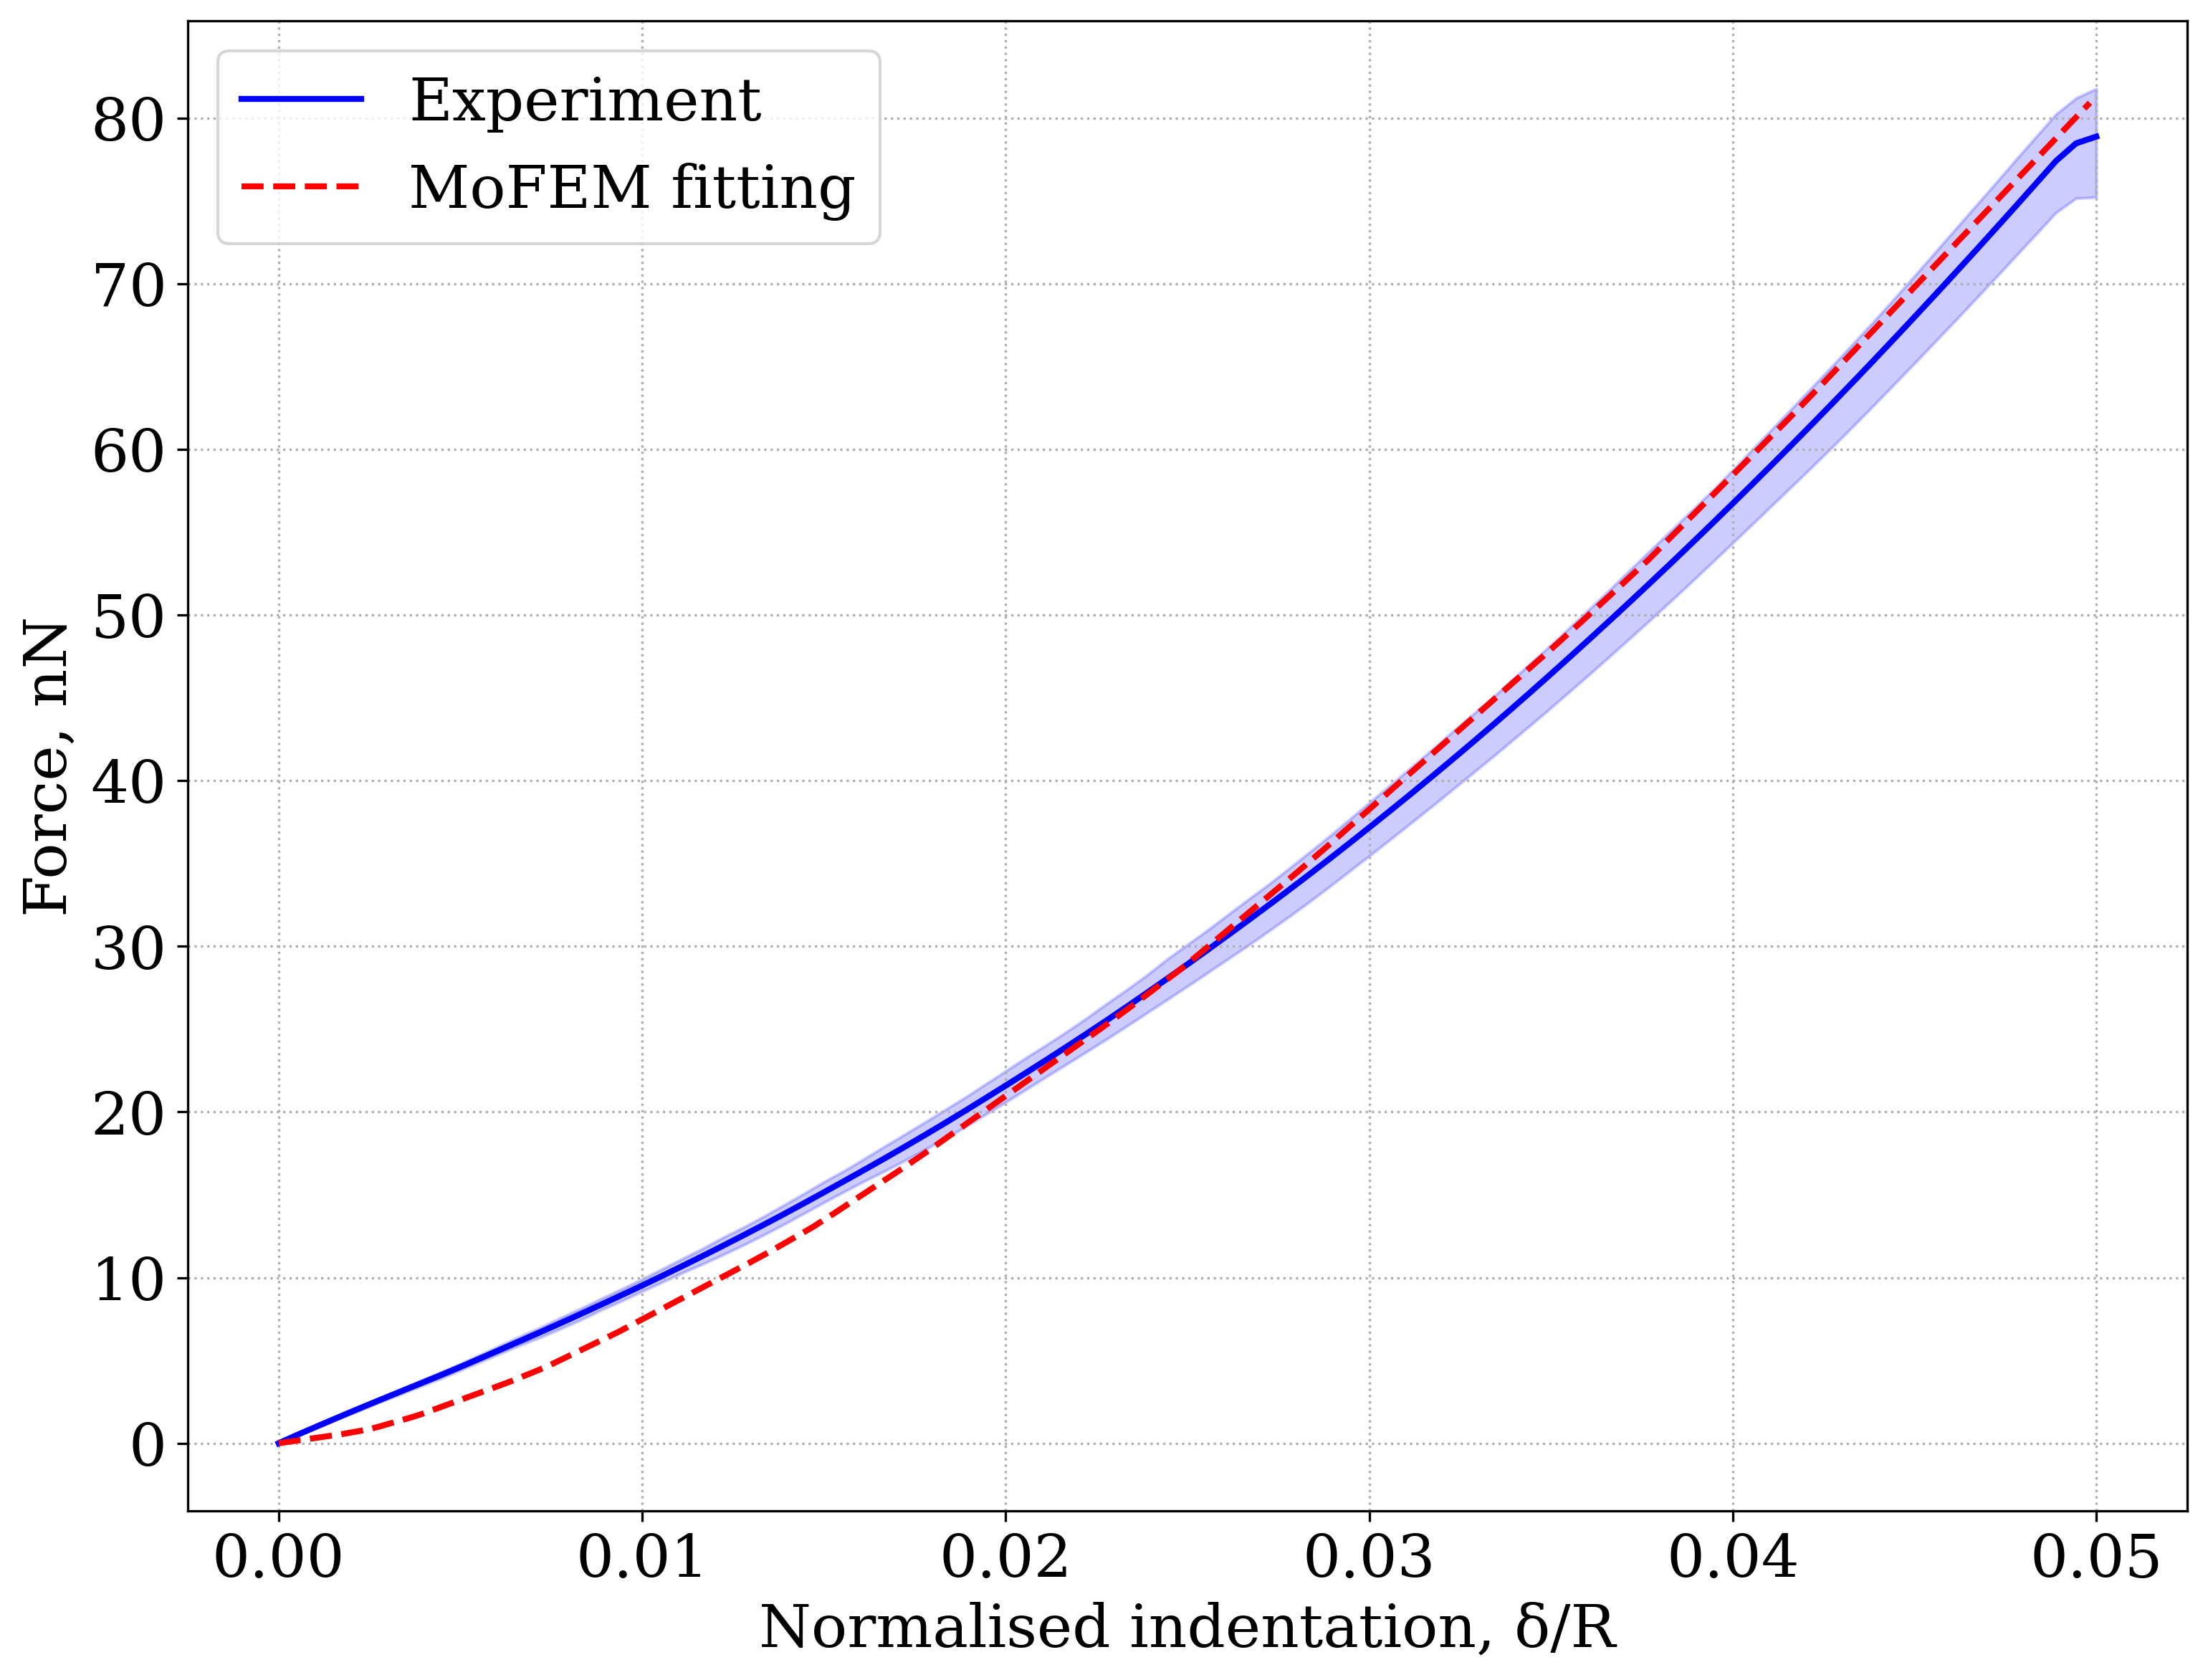

In [10]:
plt.plot(params.mean_force_df['Indentation']/ params.indenter_radius, params.mean_force_df['Mean_Force'], label='Experiment', color='blue', lw=2)
plt.fill_between(params.mean_force_df['Indentation']/ params.indenter_radius, params.mean_force_df['IQR_25'], params.mean_force_df['IQR_75'], color='blue', alpha=0.2, label=None)
plt.plot(indent_1 / params.indenter_radius, force_1, lw=2, ls="--", c='r', label="MoFEM fitting")

plt.xlabel("Normalised indentation, δ/R")
plt.ylabel("Force, nN")
plt.legend(loc='upper left')
plt.grid(ls=":")

plt.savefig('indent.png', format='png', bbox_inches='tight')